In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
def one_hot(y, batch_size):
    oh = torch.zeros([batch_size, class_size])
    for st,idx in enumerate(y):          
        oh[st][idx] = 1 
    return oh   

In [6]:
lr = 0.0001
prior_size = 100
class_size = 10
train_epoch = 1000
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)

fixed_data, fixed_cl = next(iter(test_loader))
fixed_z = torch.randn((50, 100))
fixed_oh = one_hot(y=fixed_cl[:50], batch_size=50)
fixed_h = torch.cat((fixed_z, fixed_oh), 1) 

In [7]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [8]:
G = FullyConnected([prior_size + class_size, 256, 512, 1024, 28*28], dropout=0.5, activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28 + class_size, 1024, 512, 256, 1], dropout=0.5, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [9]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [10]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [11]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, cl) in enumerate(train_loader):
        
        # train D
        D.zero_grad()
        G.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        oh = one_hot(y=cl, batch_size=batch_size)
        z_oh = torch.cat((z, oh), 1)     
        #print ('data=', data.shape)
        data_oh = torch.cat((data.view(-1, 28*28), oh), 1)
        fake_oh = torch.cat((G(z_oh), oh), 1)
                
        fake_pred = D(fake_oh)
        true_pred = D(data_oh)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
                
        fake_oh = torch.cat((G(z_oh), oh), 1)
        fake_pred = D(fake_oh)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [12]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, cl in loader:
            
            z = torch.randn((batch_size, prior_size))
            oh = one_hot(y=cl, batch_size=batch_size)
            z_oh = torch.cat((z, oh), 1)         
            data_oh = torch.cat((data.view(-1, 28*28), oh), 1)
            fake_oh = torch.cat((G(z_oh), oh), 1)
        
            fake_pred = D(fake_oh)
            true_pred = D(data_oh)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size
    
    fixed_gen = G(fixed_h).data.numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.6997, D: 0.7005
Train Epoch: 1 [5000/50000 (10%)]	Losses G: 1.2865, D: 0.6139
Train Epoch: 1 [10000/50000 (20%)]	Losses G: 1.7000, D: 0.3479
Train Epoch: 1 [15000/50000 (30%)]	Losses G: 1.9077, D: 0.3992
Train Epoch: 1 [20000/50000 (40%)]	Losses G: 1.4234, D: 0.4549
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 2.4729, D: 0.5182
Train Epoch: 1 [30000/50000 (60%)]	Losses G: 2.1938, D: 0.4908
Train Epoch: 1 [35000/50000 (70%)]	Losses G: 1.2163, D: 0.4657
Train Epoch: 1 [40000/50000 (80%)]	Losses G: 0.8810, D: 0.7648
Train Epoch: 1 [45000/50000 (90%)]	Losses G: 1.3387, D: 0.6480
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.3320, D: 0.6272


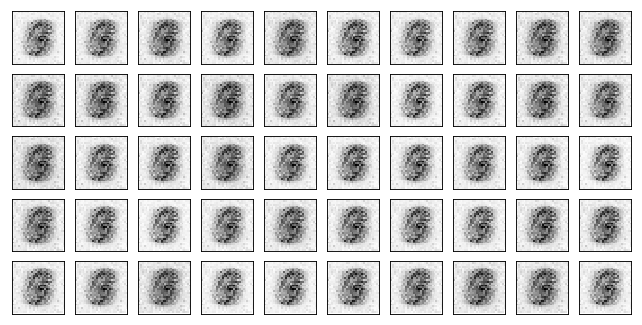

Test losses. G: 0.6461, D: 0.5746
Train Epoch: 2 [0/50000 (0%)]	Losses G: 1.0881, D: 0.6436
Train Epoch: 2 [5000/50000 (10%)]	Losses G: 1.8556, D: 0.2938
Train Epoch: 2 [10000/50000 (20%)]	Losses G: 2.0641, D: 0.3066
Train Epoch: 2 [15000/50000 (30%)]	Losses G: 1.5617, D: 0.3644
Train Epoch: 2 [20000/50000 (40%)]	Losses G: 2.8287, D: 0.1966
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 2.4156, D: 0.1632
Train Epoch: 2 [30000/50000 (60%)]	Losses G: 3.3828, D: 0.0535
Train Epoch: 2 [35000/50000 (70%)]	Losses G: 4.5228, D: 0.0178
Train Epoch: 2 [40000/50000 (80%)]	Losses G: 4.3439, D: 0.2433
Train Epoch: 2 [45000/50000 (90%)]	Losses G: 5.1337, D: 0.0275
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 4.0438, D: 0.1534


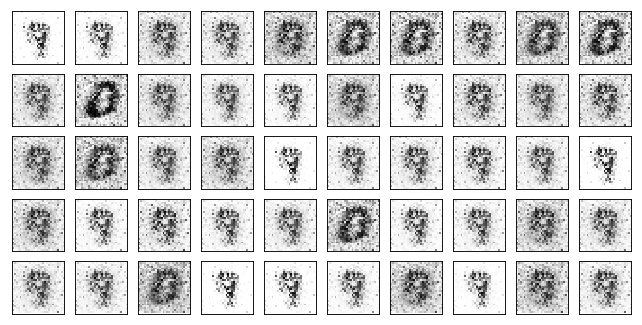

Test losses. G: 3.3269, D: 0.0312
Train Epoch: 3 [0/50000 (0%)]	Losses G: 3.6819, D: 0.2078
Train Epoch: 3 [5000/50000 (10%)]	Losses G: 4.6406, D: 0.0615
Train Epoch: 3 [10000/50000 (20%)]	Losses G: 6.0071, D: 0.0562
Train Epoch: 3 [15000/50000 (30%)]	Losses G: 3.9748, D: 0.1560
Train Epoch: 3 [20000/50000 (40%)]	Losses G: 3.9708, D: 0.1191
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 5.3045, D: 0.1636
Train Epoch: 3 [30000/50000 (60%)]	Losses G: 4.2479, D: 0.2505
Train Epoch: 3 [35000/50000 (70%)]	Losses G: 3.6393, D: 0.3336
Train Epoch: 3 [40000/50000 (80%)]	Losses G: 3.5679, D: 0.1672
Train Epoch: 3 [45000/50000 (90%)]	Losses G: 2.5117, D: 0.2246
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 5.8237, D: 0.1057


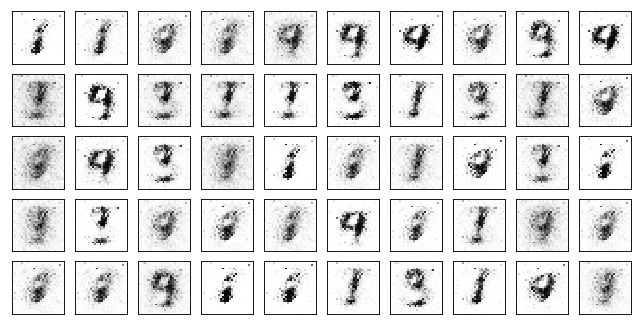

Test losses. G: 5.0138, D: 0.0581
Train Epoch: 4 [0/50000 (0%)]	Losses G: 5.1110, D: 0.1998
Train Epoch: 4 [5000/50000 (10%)]	Losses G: 4.6321, D: 0.1368
Train Epoch: 4 [10000/50000 (20%)]	Losses G: 4.8795, D: 0.2997
Train Epoch: 4 [15000/50000 (30%)]	Losses G: 4.1182, D: 0.0993
Train Epoch: 4 [20000/50000 (40%)]	Losses G: 5.7304, D: 0.0576
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 3.8701, D: 0.0893
Train Epoch: 4 [30000/50000 (60%)]	Losses G: 4.1067, D: 0.0946
Train Epoch: 4 [35000/50000 (70%)]	Losses G: 3.1861, D: 0.1703
Train Epoch: 4 [40000/50000 (80%)]	Losses G: 4.3460, D: 0.1283
Train Epoch: 4 [45000/50000 (90%)]	Losses G: 3.4833, D: 0.2796
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 2.6961, D: 0.2397


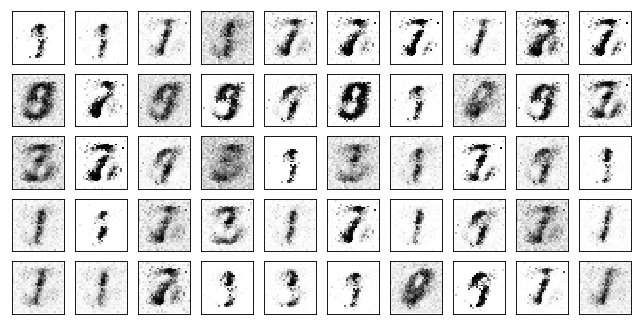

Test losses. G: 2.2657, D: 0.1076
Train Epoch: 5 [0/50000 (0%)]	Losses G: 3.2015, D: 0.2009
Train Epoch: 5 [5000/50000 (10%)]	Losses G: 3.4666, D: 0.1333
Train Epoch: 5 [10000/50000 (20%)]	Losses G: 2.8243, D: 0.2198
Train Epoch: 5 [15000/50000 (30%)]	Losses G: 3.5336, D: 0.1906
Train Epoch: 5 [20000/50000 (40%)]	Losses G: 2.9185, D: 0.1757
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 3.5096, D: 0.2058
Train Epoch: 5 [30000/50000 (60%)]	Losses G: 3.2188, D: 0.2131
Train Epoch: 5 [35000/50000 (70%)]	Losses G: 4.0645, D: 0.4007
Train Epoch: 5 [40000/50000 (80%)]	Losses G: 3.7760, D: 0.3138
Train Epoch: 5 [45000/50000 (90%)]	Losses G: 3.7372, D: 0.1096
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 3.9755, D: 0.1431


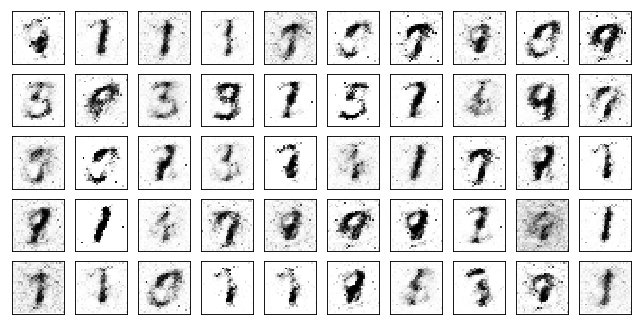

Test losses. G: 3.4831, D: 0.0568
Train Epoch: 6 [0/50000 (0%)]	Losses G: 4.4818, D: 0.2242
Train Epoch: 6 [5000/50000 (10%)]	Losses G: 3.5114, D: 0.1657
Train Epoch: 6 [10000/50000 (20%)]	Losses G: 3.1106, D: 0.1449
Train Epoch: 6 [15000/50000 (30%)]	Losses G: 3.1914, D: 0.1575
Train Epoch: 6 [20000/50000 (40%)]	Losses G: 3.3329, D: 0.1644
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 2.9512, D: 0.2344
Train Epoch: 6 [30000/50000 (60%)]	Losses G: 3.4076, D: 0.1665
Train Epoch: 6 [35000/50000 (70%)]	Losses G: 3.0038, D: 0.2072
Train Epoch: 6 [40000/50000 (80%)]	Losses G: 2.0156, D: 0.2086
Train Epoch: 6 [45000/50000 (90%)]	Losses G: 2.8687, D: 0.1624
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 3.2926, D: 0.2365


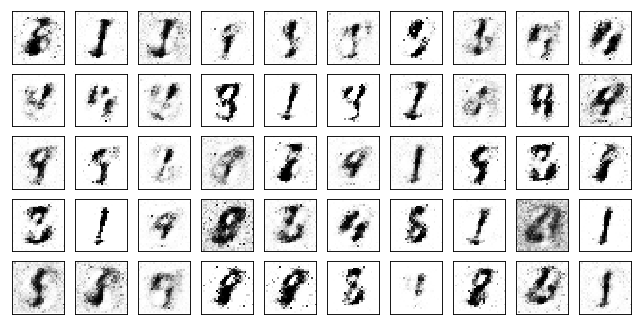

Test losses. G: 2.7918, D: 0.0960
Train Epoch: 7 [0/50000 (0%)]	Losses G: 3.5117, D: 0.2039
Train Epoch: 7 [5000/50000 (10%)]	Losses G: 3.5601, D: 0.2088
Train Epoch: 7 [10000/50000 (20%)]	Losses G: 3.8743, D: 0.1846
Train Epoch: 7 [15000/50000 (30%)]	Losses G: 3.3687, D: 0.2656
Train Epoch: 7 [20000/50000 (40%)]	Losses G: 4.1464, D: 0.1566
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 3.2439, D: 0.3392
Train Epoch: 7 [30000/50000 (60%)]	Losses G: 1.9365, D: 0.2224
Train Epoch: 7 [35000/50000 (70%)]	Losses G: 2.4969, D: 0.2830
Train Epoch: 7 [40000/50000 (80%)]	Losses G: 2.2509, D: 0.3980
Train Epoch: 7 [45000/50000 (90%)]	Losses G: 3.2990, D: 0.2777
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 2.9869, D: 0.2899


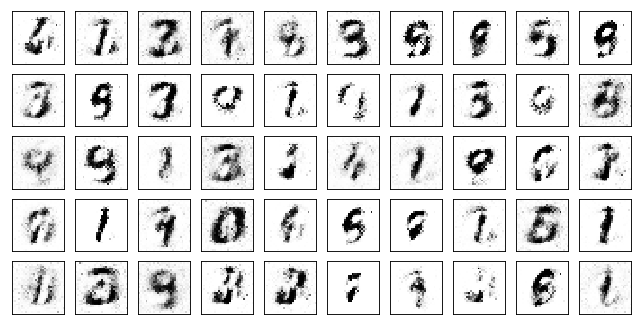

Test losses. G: 2.5953, D: 0.1722
Train Epoch: 8 [0/50000 (0%)]	Losses G: 3.0873, D: 0.2664
Train Epoch: 8 [5000/50000 (10%)]	Losses G: 2.7395, D: 0.2682
Train Epoch: 8 [10000/50000 (20%)]	Losses G: 3.7973, D: 0.3383
Train Epoch: 8 [15000/50000 (30%)]	Losses G: 2.7648, D: 0.1458
Train Epoch: 8 [20000/50000 (40%)]	Losses G: 2.8176, D: 0.2559
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 3.3316, D: 0.2938
Train Epoch: 8 [30000/50000 (60%)]	Losses G: 2.6471, D: 0.1745
Train Epoch: 8 [35000/50000 (70%)]	Losses G: 2.7047, D: 0.1957
Train Epoch: 8 [40000/50000 (80%)]	Losses G: 2.7641, D: 0.2660
Train Epoch: 8 [45000/50000 (90%)]	Losses G: 3.3653, D: 0.3045
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 2.3083, D: 0.3134


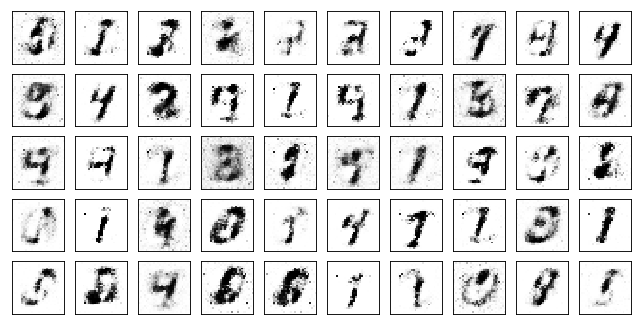

Test losses. G: 2.1578, D: 0.1500
Train Epoch: 9 [0/50000 (0%)]	Losses G: 2.3166, D: 0.2775
Train Epoch: 9 [5000/50000 (10%)]	Losses G: 2.9715, D: 0.2541
Train Epoch: 9 [10000/50000 (20%)]	Losses G: 2.1402, D: 0.2947
Train Epoch: 9 [15000/50000 (30%)]	Losses G: 2.5398, D: 0.2901
Train Epoch: 9 [20000/50000 (40%)]	Losses G: 3.4671, D: 0.3028
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 3.3793, D: 0.2880
Train Epoch: 9 [30000/50000 (60%)]	Losses G: 2.3476, D: 0.1721
Train Epoch: 9 [35000/50000 (70%)]	Losses G: 2.3031, D: 0.1751
Train Epoch: 9 [40000/50000 (80%)]	Losses G: 2.5330, D: 0.3190
Train Epoch: 9 [45000/50000 (90%)]	Losses G: 2.9259, D: 0.1825
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 2.5812, D: 0.2447


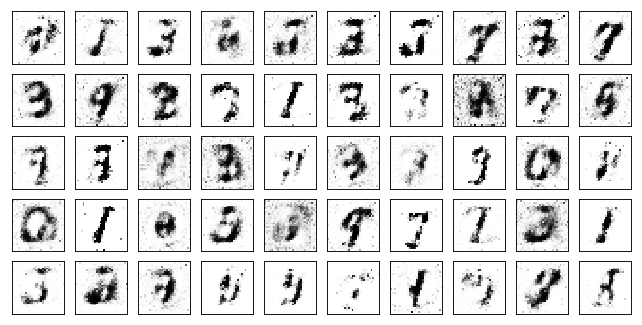

Test losses. G: 2.3895, D: 0.1652
Train Epoch: 10 [0/50000 (0%)]	Losses G: 2.1858, D: 0.2725
Train Epoch: 10 [5000/50000 (10%)]	Losses G: 2.5812, D: 0.5105
Train Epoch: 10 [10000/50000 (20%)]	Losses G: 1.5709, D: 0.3708
Train Epoch: 10 [15000/50000 (30%)]	Losses G: 2.6079, D: 0.4107
Train Epoch: 10 [20000/50000 (40%)]	Losses G: 2.0374, D: 0.2482
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 2.8690, D: 0.2357
Train Epoch: 10 [30000/50000 (60%)]	Losses G: 2.0171, D: 0.2742
Train Epoch: 10 [35000/50000 (70%)]	Losses G: 2.8539, D: 0.3985
Train Epoch: 10 [40000/50000 (80%)]	Losses G: 2.8109, D: 0.2451
Train Epoch: 10 [45000/50000 (90%)]	Losses G: 2.6264, D: 0.3822
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 2.4870, D: 0.2776


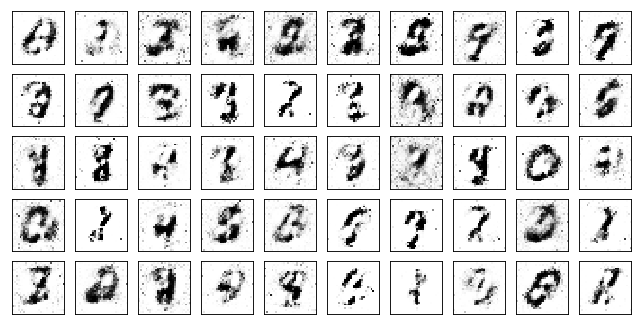

Test losses. G: 2.1289, D: 0.1832
Train Epoch: 11 [0/50000 (0%)]	Losses G: 2.0677, D: 0.3642
Train Epoch: 11 [5000/50000 (10%)]	Losses G: 2.4208, D: 0.2425
Train Epoch: 11 [10000/50000 (20%)]	Losses G: 2.1871, D: 0.2371
Train Epoch: 11 [15000/50000 (30%)]	Losses G: 2.8193, D: 0.2214
Train Epoch: 11 [20000/50000 (40%)]	Losses G: 2.5412, D: 0.2903
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 2.3322, D: 0.3566
Train Epoch: 11 [30000/50000 (60%)]	Losses G: 2.9602, D: 0.2787
Train Epoch: 11 [35000/50000 (70%)]	Losses G: 2.6431, D: 0.2946
Train Epoch: 11 [40000/50000 (80%)]	Losses G: 2.8374, D: 0.2119
Train Epoch: 11 [45000/50000 (90%)]	Losses G: 2.2378, D: 0.2456
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 2.5662, D: 0.4268


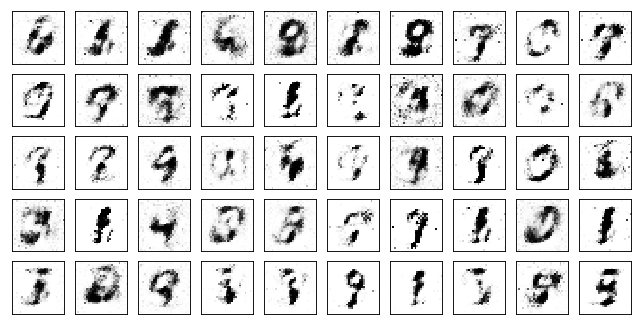

Test losses. G: 2.3761, D: 0.3200
Train Epoch: 12 [0/50000 (0%)]	Losses G: 2.5198, D: 0.5072
Train Epoch: 12 [5000/50000 (10%)]	Losses G: 2.3135, D: 0.4594
Train Epoch: 12 [10000/50000 (20%)]	Losses G: 2.3660, D: 0.2647
Train Epoch: 12 [15000/50000 (30%)]	Losses G: 2.5091, D: 0.3034
Train Epoch: 12 [20000/50000 (40%)]	Losses G: 3.3737, D: 0.2404
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 4.0257, D: 0.1513
Train Epoch: 12 [30000/50000 (60%)]	Losses G: 3.6493, D: 0.2605
Train Epoch: 12 [35000/50000 (70%)]	Losses G: 2.7872, D: 0.2285
Train Epoch: 12 [40000/50000 (80%)]	Losses G: 2.5124, D: 0.3696
Train Epoch: 12 [45000/50000 (90%)]	Losses G: 2.1422, D: 0.2937
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 2.5963, D: 0.2494


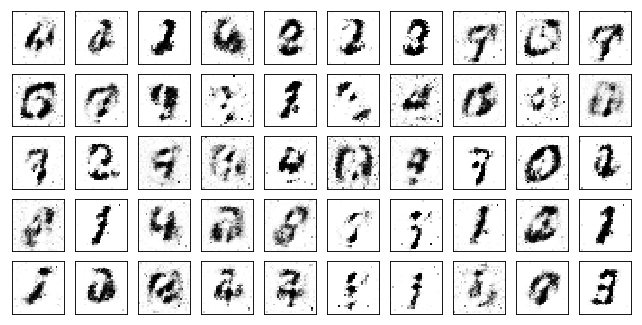

Test losses. G: 2.6027, D: 0.1264
Train Epoch: 13 [0/50000 (0%)]	Losses G: 2.1459, D: 0.2960
Train Epoch: 13 [5000/50000 (10%)]	Losses G: 2.3804, D: 0.2459
Train Epoch: 13 [10000/50000 (20%)]	Losses G: 2.4146, D: 0.3042
Train Epoch: 13 [15000/50000 (30%)]	Losses G: 3.2975, D: 0.2858
Train Epoch: 13 [20000/50000 (40%)]	Losses G: 2.9710, D: 0.2333
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 2.7854, D: 0.2192
Train Epoch: 13 [30000/50000 (60%)]	Losses G: 2.5280, D: 0.1774
Train Epoch: 13 [35000/50000 (70%)]	Losses G: 3.1693, D: 0.2014
Train Epoch: 13 [40000/50000 (80%)]	Losses G: 2.8530, D: 0.2636
Train Epoch: 13 [45000/50000 (90%)]	Losses G: 2.5096, D: 0.1854
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 2.0821, D: 0.3350


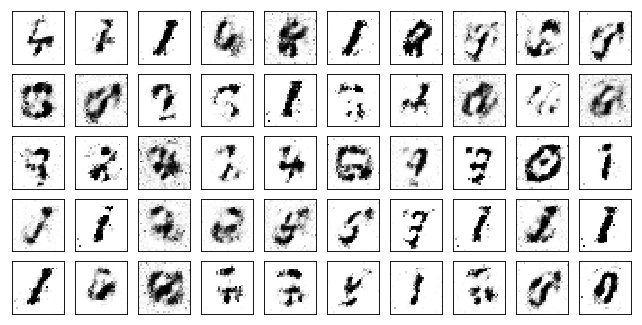

Test losses. G: 2.2011, D: 0.1713
Train Epoch: 14 [0/50000 (0%)]	Losses G: 2.1889, D: 0.2895
Train Epoch: 14 [5000/50000 (10%)]	Losses G: 2.4295, D: 0.3489
Train Epoch: 14 [10000/50000 (20%)]	Losses G: 1.6383, D: 0.4429
Train Epoch: 14 [15000/50000 (30%)]	Losses G: 1.8423, D: 0.4589
Train Epoch: 14 [20000/50000 (40%)]	Losses G: 1.7288, D: 0.3546
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 2.4368, D: 0.2909
Train Epoch: 14 [30000/50000 (60%)]	Losses G: 2.3480, D: 0.2433
Train Epoch: 14 [35000/50000 (70%)]	Losses G: 2.4051, D: 0.3351
Train Epoch: 14 [40000/50000 (80%)]	Losses G: 2.4367, D: 0.2471
Train Epoch: 14 [45000/50000 (90%)]	Losses G: 2.8261, D: 0.2320
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 2.3651, D: 0.4084


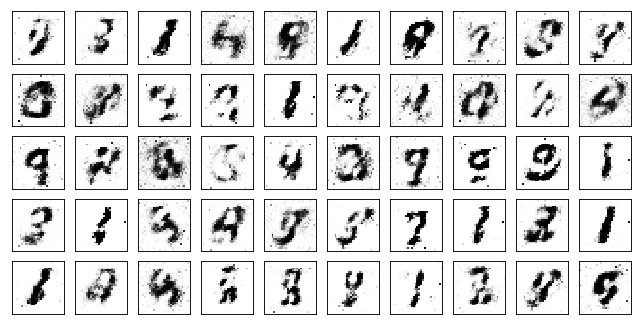

Test losses. G: 1.8968, D: 0.2872
Train Epoch: 15 [0/50000 (0%)]	Losses G: 1.6149, D: 0.4180
Train Epoch: 15 [5000/50000 (10%)]	Losses G: 1.8691, D: 0.4619
Train Epoch: 15 [10000/50000 (20%)]	Losses G: 2.2941, D: 0.4078
Train Epoch: 15 [15000/50000 (30%)]	Losses G: 2.6352, D: 0.3602
Train Epoch: 15 [20000/50000 (40%)]	Losses G: 2.7856, D: 0.2607
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 2.3948, D: 0.3624
Train Epoch: 15 [30000/50000 (60%)]	Losses G: 1.8727, D: 0.3608
Train Epoch: 15 [35000/50000 (70%)]	Losses G: 2.2864, D: 0.4821
Train Epoch: 15 [40000/50000 (80%)]	Losses G: 1.8555, D: 0.4620
Train Epoch: 15 [45000/50000 (90%)]	Losses G: 2.3465, D: 0.5650
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 1.9964, D: 0.3918


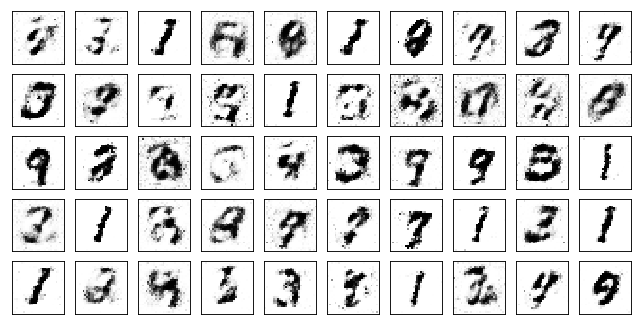

Test losses. G: 1.8606, D: 0.2351
Train Epoch: 16 [0/50000 (0%)]	Losses G: 2.4158, D: 0.3748
Train Epoch: 16 [5000/50000 (10%)]	Losses G: 2.5961, D: 0.2449
Train Epoch: 16 [10000/50000 (20%)]	Losses G: 2.6853, D: 0.2992
Train Epoch: 16 [15000/50000 (30%)]	Losses G: 1.6841, D: 0.2797
Train Epoch: 16 [20000/50000 (40%)]	Losses G: 2.2151, D: 0.4023
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 1.6856, D: 0.3854
Train Epoch: 16 [30000/50000 (60%)]	Losses G: 1.5325, D: 0.4075
Train Epoch: 16 [35000/50000 (70%)]	Losses G: 2.1538, D: 0.4105
Train Epoch: 16 [40000/50000 (80%)]	Losses G: 2.1928, D: 0.2922
Train Epoch: 16 [45000/50000 (90%)]	Losses G: 2.6198, D: 0.2689
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 2.0426, D: 0.3114


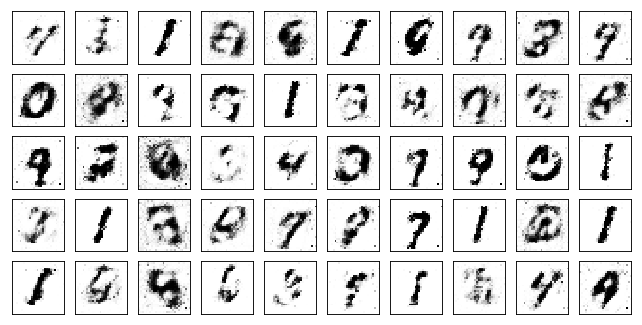

Test losses. G: 1.8029, D: 0.2613
Train Epoch: 17 [0/50000 (0%)]	Losses G: 1.8458, D: 0.4348
Train Epoch: 17 [5000/50000 (10%)]	Losses G: 1.8317, D: 0.4597
Train Epoch: 17 [10000/50000 (20%)]	Losses G: 2.4574, D: 0.5342
Train Epoch: 17 [15000/50000 (30%)]	Losses G: 1.8616, D: 0.4930
Train Epoch: 17 [20000/50000 (40%)]	Losses G: 2.0618, D: 0.4311
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 1.7959, D: 0.3769
Train Epoch: 17 [30000/50000 (60%)]	Losses G: 1.9990, D: 0.3235
Train Epoch: 17 [35000/50000 (70%)]	Losses G: 2.2041, D: 0.3784
Train Epoch: 17 [40000/50000 (80%)]	Losses G: 2.7370, D: 0.2618
Train Epoch: 17 [45000/50000 (90%)]	Losses G: 2.2269, D: 0.3655
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 2.0484, D: 0.2939


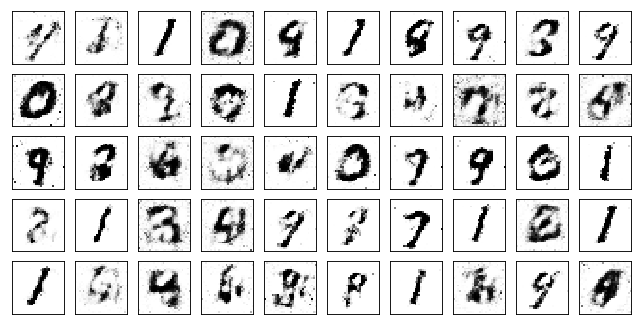

Test losses. G: 1.7794, D: 0.2137
Train Epoch: 18 [0/50000 (0%)]	Losses G: 1.8737, D: 0.3433
Train Epoch: 18 [5000/50000 (10%)]	Losses G: 2.7502, D: 0.2272
Train Epoch: 18 [10000/50000 (20%)]	Losses G: 2.0017, D: 0.2977
Train Epoch: 18 [15000/50000 (30%)]	Losses G: 2.0129, D: 0.3465
Train Epoch: 18 [20000/50000 (40%)]	Losses G: 1.7126, D: 0.4545
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 2.8854, D: 0.2494
Train Epoch: 18 [30000/50000 (60%)]	Losses G: 2.3630, D: 0.3874
Train Epoch: 18 [35000/50000 (70%)]	Losses G: 1.9219, D: 0.3623
Train Epoch: 18 [40000/50000 (80%)]	Losses G: 1.5063, D: 0.4536
Train Epoch: 18 [45000/50000 (90%)]	Losses G: 2.6945, D: 0.3079
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 2.2746, D: 0.3632


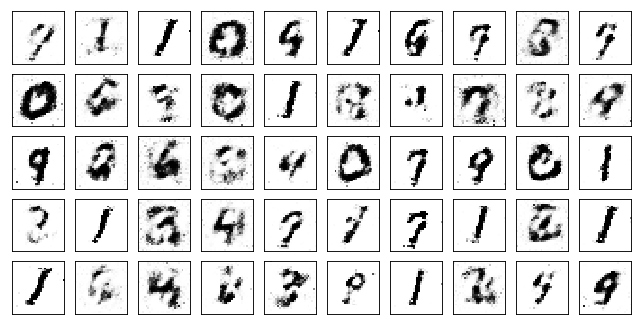

Test losses. G: 2.2745, D: 0.2009
Train Epoch: 19 [0/50000 (0%)]	Losses G: 2.0824, D: 0.2695
Train Epoch: 19 [5000/50000 (10%)]	Losses G: 1.8683, D: 0.3138
Train Epoch: 19 [10000/50000 (20%)]	Losses G: 2.3656, D: 0.2603
Train Epoch: 19 [15000/50000 (30%)]	Losses G: 1.7905, D: 0.3322
Train Epoch: 19 [20000/50000 (40%)]	Losses G: 1.9687, D: 0.3791
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 2.0578, D: 0.3351
Train Epoch: 19 [30000/50000 (60%)]	Losses G: 2.1125, D: 0.3308
Train Epoch: 19 [35000/50000 (70%)]	Losses G: 2.6461, D: 0.3084
Train Epoch: 19 [40000/50000 (80%)]	Losses G: 2.0710, D: 0.3535
Train Epoch: 19 [45000/50000 (90%)]	Losses G: 1.6589, D: 0.4750
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 2.6312, D: 0.3074


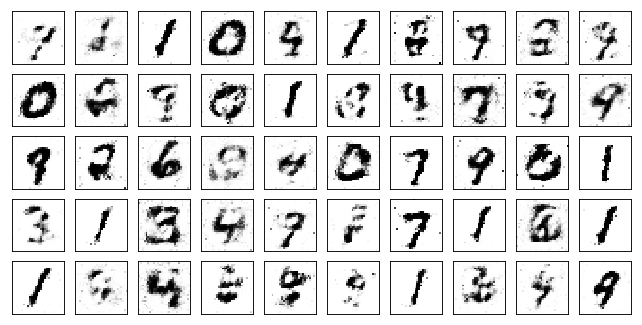

Test losses. G: 2.1908, D: 0.2542
Train Epoch: 20 [0/50000 (0%)]	Losses G: 2.0739, D: 0.3443
Train Epoch: 20 [5000/50000 (10%)]	Losses G: 1.9694, D: 0.3627
Train Epoch: 20 [10000/50000 (20%)]	Losses G: 1.6915, D: 0.3843
Train Epoch: 20 [15000/50000 (30%)]	Losses G: 1.4014, D: 0.6479
Train Epoch: 20 [20000/50000 (40%)]	Losses G: 1.5694, D: 0.5035
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 2.2220, D: 0.2586
Train Epoch: 20 [30000/50000 (60%)]	Losses G: 2.1899, D: 0.4188
Train Epoch: 20 [35000/50000 (70%)]	Losses G: 1.6292, D: 0.4415
Train Epoch: 20 [40000/50000 (80%)]	Losses G: 1.5111, D: 0.4817
Train Epoch: 20 [45000/50000 (90%)]	Losses G: 1.9971, D: 0.4666
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 1.7764, D: 0.3665


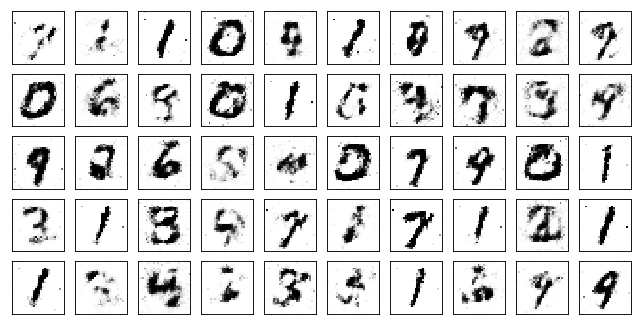

Test losses. G: 1.7948, D: 0.2306
Train Epoch: 21 [0/50000 (0%)]	Losses G: 2.0881, D: 0.2422
Train Epoch: 21 [5000/50000 (10%)]	Losses G: 1.8072, D: 0.4332
Train Epoch: 21 [10000/50000 (20%)]	Losses G: 1.9613, D: 0.3928
Train Epoch: 21 [15000/50000 (30%)]	Losses G: 1.1907, D: 0.4774
Train Epoch: 21 [20000/50000 (40%)]	Losses G: 1.5575, D: 0.4709
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 1.9480, D: 0.4039
Train Epoch: 21 [30000/50000 (60%)]	Losses G: 1.6112, D: 0.3010
Train Epoch: 21 [35000/50000 (70%)]	Losses G: 1.8493, D: 0.3579
Train Epoch: 21 [40000/50000 (80%)]	Losses G: 1.6552, D: 0.4439
Train Epoch: 21 [45000/50000 (90%)]	Losses G: 0.9836, D: 0.4585
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 2.1665, D: 0.4761


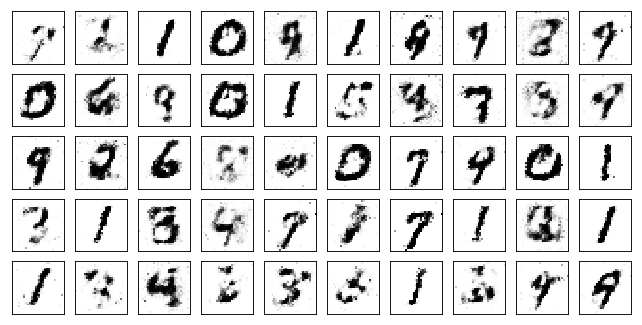

Test losses. G: 1.6396, D: 0.3073
Train Epoch: 22 [0/50000 (0%)]	Losses G: 1.7059, D: 0.5074
Train Epoch: 22 [5000/50000 (10%)]	Losses G: 1.8981, D: 0.4928
Train Epoch: 22 [10000/50000 (20%)]	Losses G: 2.2935, D: 0.3128
Train Epoch: 22 [15000/50000 (30%)]	Losses G: 1.8253, D: 0.4308
Train Epoch: 22 [20000/50000 (40%)]	Losses G: 1.8651, D: 0.5315
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 1.5618, D: 0.3705
Train Epoch: 22 [30000/50000 (60%)]	Losses G: 1.2411, D: 0.4555
Train Epoch: 22 [35000/50000 (70%)]	Losses G: 1.4957, D: 0.3581
Train Epoch: 22 [40000/50000 (80%)]	Losses G: 2.1139, D: 0.3999
Train Epoch: 22 [45000/50000 (90%)]	Losses G: 2.1435, D: 0.3234
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 2.1124, D: 0.3438


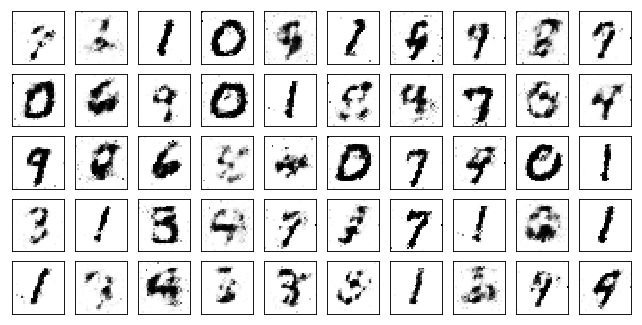

Test losses. G: 1.8657, D: 0.2611
Train Epoch: 23 [0/50000 (0%)]	Losses G: 1.8959, D: 0.3035
Train Epoch: 23 [5000/50000 (10%)]	Losses G: 1.7203, D: 0.4587
Train Epoch: 23 [10000/50000 (20%)]	Losses G: 1.5252, D: 0.5337
Train Epoch: 23 [15000/50000 (30%)]	Losses G: 1.7800, D: 0.5580
Train Epoch: 23 [20000/50000 (40%)]	Losses G: 1.3821, D: 0.4131
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 1.1028, D: 0.4725
Train Epoch: 23 [30000/50000 (60%)]	Losses G: 1.7540, D: 0.3982
Train Epoch: 23 [35000/50000 (70%)]	Losses G: 1.8214, D: 0.3871
Train Epoch: 23 [40000/50000 (80%)]	Losses G: 1.8435, D: 0.3372
Train Epoch: 23 [45000/50000 (90%)]	Losses G: 1.7793, D: 0.4955
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 1.1783, D: 0.5091


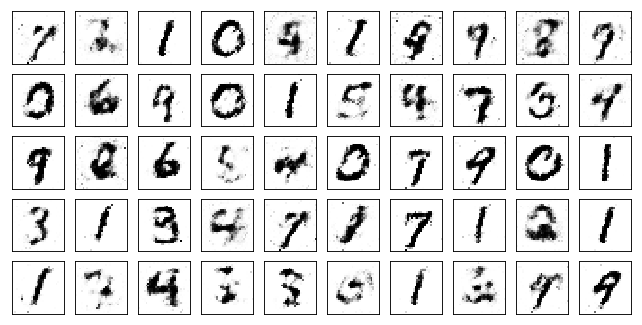

Test losses. G: 1.3092, D: 0.4068
Train Epoch: 24 [0/50000 (0%)]	Losses G: 1.2870, D: 0.5988
Train Epoch: 24 [5000/50000 (10%)]	Losses G: 1.0829, D: 0.6237
Train Epoch: 24 [10000/50000 (20%)]	Losses G: 1.4281, D: 0.4306
Train Epoch: 24 [15000/50000 (30%)]	Losses G: 1.8066, D: 0.3944
Train Epoch: 24 [20000/50000 (40%)]	Losses G: 1.0700, D: 0.4699
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 1.2531, D: 0.5551
Train Epoch: 24 [30000/50000 (60%)]	Losses G: 2.0414, D: 0.4066
Train Epoch: 24 [35000/50000 (70%)]	Losses G: 1.6341, D: 0.4765
Train Epoch: 24 [40000/50000 (80%)]	Losses G: 1.3967, D: 0.4892
Train Epoch: 24 [45000/50000 (90%)]	Losses G: 1.9271, D: 0.3559
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 1.4416, D: 0.4307


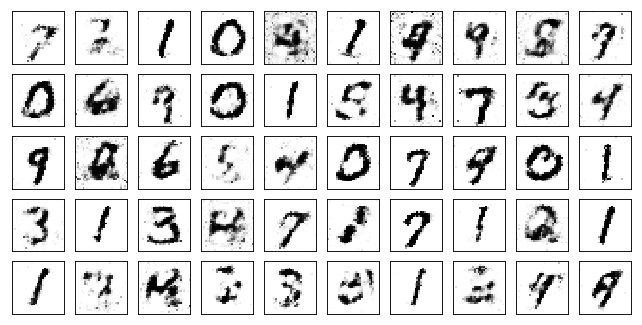

Test losses. G: 1.6860, D: 0.2933
Train Epoch: 25 [0/50000 (0%)]	Losses G: 1.8632, D: 0.4002
Train Epoch: 25 [5000/50000 (10%)]	Losses G: 1.4060, D: 0.4580
Train Epoch: 25 [10000/50000 (20%)]	Losses G: 1.6013, D: 0.4806
Train Epoch: 25 [15000/50000 (30%)]	Losses G: 1.7340, D: 0.4142
Train Epoch: 25 [20000/50000 (40%)]	Losses G: 1.7665, D: 0.3169
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 1.7431, D: 0.3976
Train Epoch: 25 [30000/50000 (60%)]	Losses G: 1.1523, D: 0.4978
Train Epoch: 25 [35000/50000 (70%)]	Losses G: 1.4870, D: 0.5322
Train Epoch: 25 [40000/50000 (80%)]	Losses G: 1.4228, D: 0.5044
Train Epoch: 25 [45000/50000 (90%)]	Losses G: 1.6840, D: 0.4158
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 1.8408, D: 0.4762


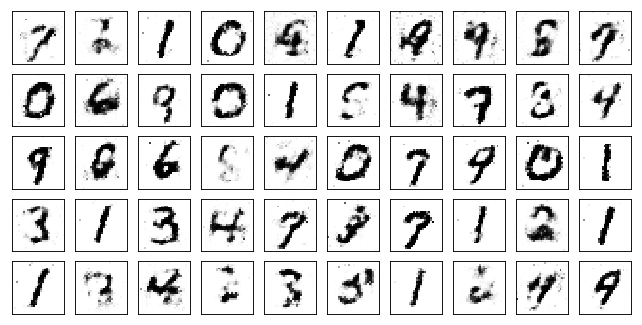

Test losses. G: 1.6348, D: 0.3260
Train Epoch: 26 [0/50000 (0%)]	Losses G: 1.6101, D: 0.4131
Train Epoch: 26 [5000/50000 (10%)]	Losses G: 1.7101, D: 0.3805
Train Epoch: 26 [10000/50000 (20%)]	Losses G: 1.6429, D: 0.4524
Train Epoch: 26 [15000/50000 (30%)]	Losses G: 1.8293, D: 0.4332
Train Epoch: 26 [20000/50000 (40%)]	Losses G: 1.2210, D: 0.4838
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 1.4472, D: 0.4799
Train Epoch: 26 [30000/50000 (60%)]	Losses G: 1.3187, D: 0.6523
Train Epoch: 26 [35000/50000 (70%)]	Losses G: 0.8699, D: 0.4453
Train Epoch: 26 [40000/50000 (80%)]	Losses G: 1.7789, D: 0.4391
Train Epoch: 26 [45000/50000 (90%)]	Losses G: 1.8682, D: 0.3792
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 1.5884, D: 0.4471


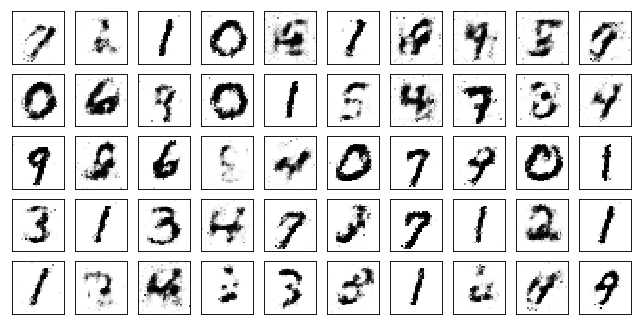

Test losses. G: 1.8925, D: 0.3608
Train Epoch: 27 [0/50000 (0%)]	Losses G: 1.8936, D: 0.4810
Train Epoch: 27 [5000/50000 (10%)]	Losses G: 1.2694, D: 0.5334
Train Epoch: 27 [10000/50000 (20%)]	Losses G: 1.6372, D: 0.4888
Train Epoch: 27 [15000/50000 (30%)]	Losses G: 1.2891, D: 0.4733
Train Epoch: 27 [20000/50000 (40%)]	Losses G: 1.6626, D: 0.4536
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 1.1326, D: 0.4761
Train Epoch: 27 [30000/50000 (60%)]	Losses G: 1.6987, D: 0.5390
Train Epoch: 27 [35000/50000 (70%)]	Losses G: 1.8324, D: 0.4115
Train Epoch: 27 [40000/50000 (80%)]	Losses G: 1.9688, D: 0.4928
Train Epoch: 27 [45000/50000 (90%)]	Losses G: 1.3481, D: 0.5540
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 1.1943, D: 0.5111


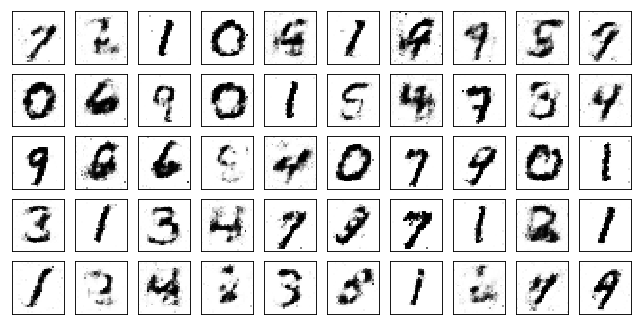

Test losses. G: 1.1500, D: 0.4384
Train Epoch: 28 [0/50000 (0%)]	Losses G: 1.1233, D: 0.5431
Train Epoch: 28 [5000/50000 (10%)]	Losses G: 1.4665, D: 0.4067
Train Epoch: 28 [10000/50000 (20%)]	Losses G: 1.4874, D: 0.4117
Train Epoch: 28 [15000/50000 (30%)]	Losses G: 1.4055, D: 0.5253
Train Epoch: 28 [20000/50000 (40%)]	Losses G: 1.4959, D: 0.5531
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 1.5660, D: 0.5575
Train Epoch: 28 [30000/50000 (60%)]	Losses G: 1.4757, D: 0.5445
Train Epoch: 28 [35000/50000 (70%)]	Losses G: 1.8903, D: 0.3985
Train Epoch: 28 [40000/50000 (80%)]	Losses G: 1.9595, D: 0.4787
Train Epoch: 28 [45000/50000 (90%)]	Losses G: 1.6818, D: 0.4404
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 1.2296, D: 0.5896


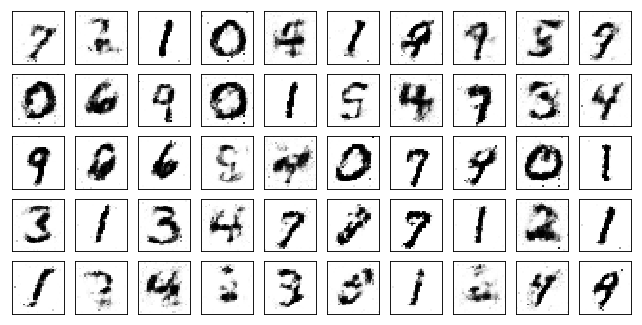

Test losses. G: 1.3466, D: 0.4581
Train Epoch: 29 [0/50000 (0%)]	Losses G: 1.4201, D: 0.5192
Train Epoch: 29 [5000/50000 (10%)]	Losses G: 1.1275, D: 0.4676
Train Epoch: 29 [10000/50000 (20%)]	Losses G: 1.6400, D: 0.4427
Train Epoch: 29 [15000/50000 (30%)]	Losses G: 1.6208, D: 0.4156
Train Epoch: 29 [20000/50000 (40%)]	Losses G: 1.3401, D: 0.3887
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 1.4028, D: 0.4891
Train Epoch: 29 [30000/50000 (60%)]	Losses G: 1.2179, D: 0.6340
Train Epoch: 29 [35000/50000 (70%)]	Losses G: 1.1017, D: 0.4622
Train Epoch: 29 [40000/50000 (80%)]	Losses G: 1.2994, D: 0.4885
Train Epoch: 29 [45000/50000 (90%)]	Losses G: 1.2827, D: 0.4531
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 1.2276, D: 0.4627


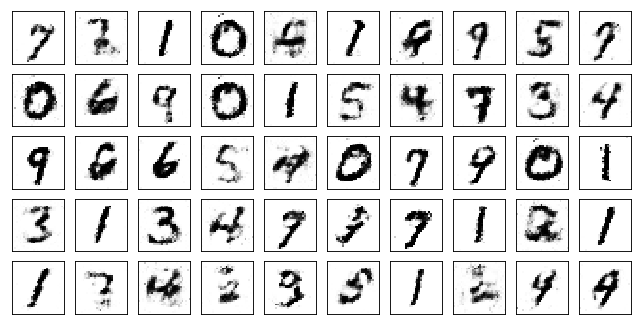

Test losses. G: 1.2460, D: 0.4429
Train Epoch: 30 [0/50000 (0%)]	Losses G: 1.2048, D: 0.6126
Train Epoch: 30 [5000/50000 (10%)]	Losses G: 1.4281, D: 0.6015
Train Epoch: 30 [10000/50000 (20%)]	Losses G: 1.8236, D: 0.3930
Train Epoch: 30 [15000/50000 (30%)]	Losses G: 1.5020, D: 0.4783
Train Epoch: 30 [20000/50000 (40%)]	Losses G: 1.0631, D: 0.5863
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 1.1221, D: 0.6183
Train Epoch: 30 [30000/50000 (60%)]	Losses G: 1.5576, D: 0.4694
Train Epoch: 30 [35000/50000 (70%)]	Losses G: 1.7097, D: 0.4118
Train Epoch: 30 [40000/50000 (80%)]	Losses G: 1.7411, D: 0.4436
Train Epoch: 30 [45000/50000 (90%)]	Losses G: 1.3206, D: 0.5518
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 1.3972, D: 0.5668


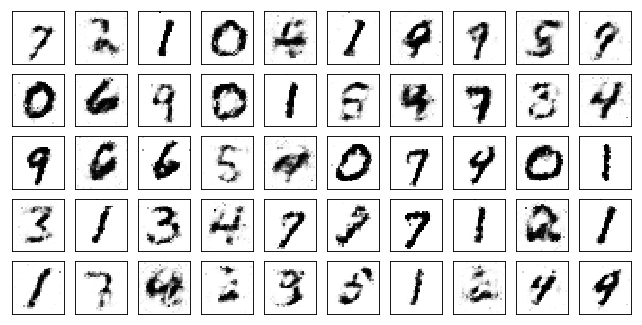

Test losses. G: 1.3586, D: 0.4561
Train Epoch: 31 [0/50000 (0%)]	Losses G: 1.3856, D: 0.4919
Train Epoch: 31 [5000/50000 (10%)]	Losses G: 1.3160, D: 0.4960
Train Epoch: 31 [10000/50000 (20%)]	Losses G: 1.6806, D: 0.4886
Train Epoch: 31 [15000/50000 (30%)]	Losses G: 1.5804, D: 0.4178
Train Epoch: 31 [20000/50000 (40%)]	Losses G: 1.6235, D: 0.4388
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 1.1460, D: 0.5935
Train Epoch: 31 [30000/50000 (60%)]	Losses G: 1.6187, D: 0.5087
Train Epoch: 31 [35000/50000 (70%)]	Losses G: 1.5340, D: 0.5308
Train Epoch: 31 [40000/50000 (80%)]	Losses G: 1.0403, D: 0.5696
Train Epoch: 31 [45000/50000 (90%)]	Losses G: 1.6088, D: 0.5022
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 1.1690, D: 0.4889


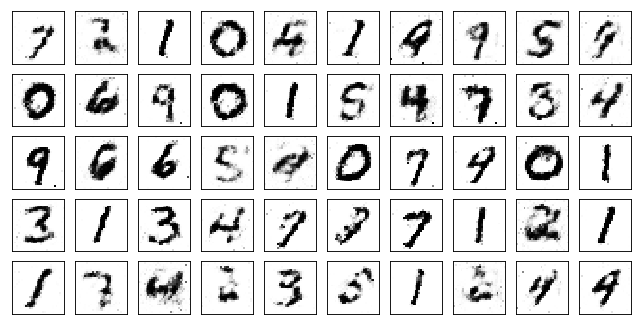

Test losses. G: 1.3383, D: 0.4063
Train Epoch: 32 [0/50000 (0%)]	Losses G: 1.5014, D: 0.4869
Train Epoch: 32 [5000/50000 (10%)]	Losses G: 1.1988, D: 0.5052
Train Epoch: 32 [10000/50000 (20%)]	Losses G: 1.6567, D: 0.4936
Train Epoch: 32 [15000/50000 (30%)]	Losses G: 1.4897, D: 0.3480
Train Epoch: 32 [20000/50000 (40%)]	Losses G: 1.6376, D: 0.4140
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 1.6968, D: 0.4451
Train Epoch: 32 [30000/50000 (60%)]	Losses G: 1.7828, D: 0.4295
Train Epoch: 32 [35000/50000 (70%)]	Losses G: 1.1850, D: 0.6124
Train Epoch: 32 [40000/50000 (80%)]	Losses G: 1.4327, D: 0.5317
Train Epoch: 32 [45000/50000 (90%)]	Losses G: 1.2614, D: 0.5122
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 1.4178, D: 0.4400


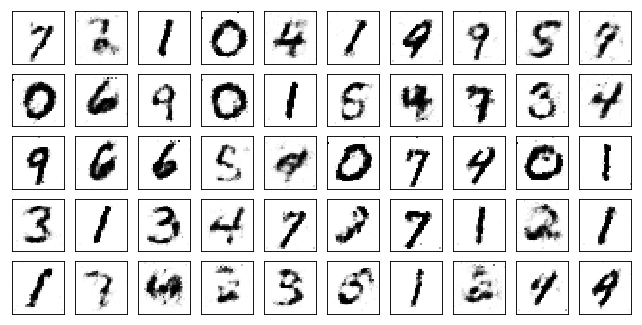

Test losses. G: 1.1890, D: 0.3899
Train Epoch: 33 [0/50000 (0%)]	Losses G: 1.2709, D: 0.5111
Train Epoch: 33 [5000/50000 (10%)]	Losses G: 1.6971, D: 0.5073
Train Epoch: 33 [10000/50000 (20%)]	Losses G: 1.4892, D: 0.5360
Train Epoch: 33 [15000/50000 (30%)]	Losses G: 1.3313, D: 0.6144
Train Epoch: 33 [20000/50000 (40%)]	Losses G: 1.4548, D: 0.5271
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 1.5289, D: 0.4012
Train Epoch: 33 [30000/50000 (60%)]	Losses G: 1.3128, D: 0.4749
Train Epoch: 33 [35000/50000 (70%)]	Losses G: 1.1396, D: 0.4583
Train Epoch: 33 [40000/50000 (80%)]	Losses G: 1.2717, D: 0.5411
Train Epoch: 33 [45000/50000 (90%)]	Losses G: 1.2413, D: 0.3997
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 1.4891, D: 0.5560


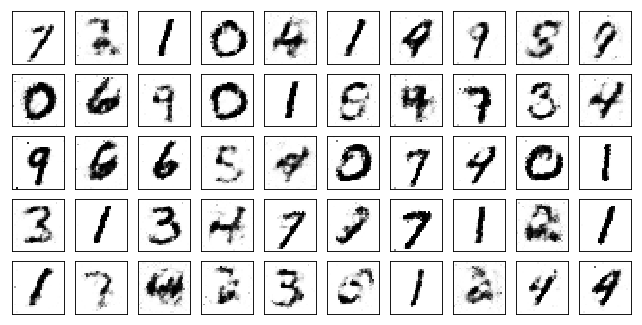

Test losses. G: 1.3597, D: 0.4426
Train Epoch: 34 [0/50000 (0%)]	Losses G: 1.4807, D: 0.4629
Train Epoch: 34 [5000/50000 (10%)]	Losses G: 1.3052, D: 0.5380
Train Epoch: 34 [10000/50000 (20%)]	Losses G: 1.9044, D: 0.4271
Train Epoch: 34 [15000/50000 (30%)]	Losses G: 1.2555, D: 0.4594
Train Epoch: 34 [20000/50000 (40%)]	Losses G: 1.1859, D: 0.5942
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 1.5529, D: 0.5828
Train Epoch: 34 [30000/50000 (60%)]	Losses G: 1.4876, D: 0.4357
Train Epoch: 34 [35000/50000 (70%)]	Losses G: 1.2523, D: 0.4319
Train Epoch: 34 [40000/50000 (80%)]	Losses G: 1.3362, D: 0.4308
Train Epoch: 34 [45000/50000 (90%)]	Losses G: 1.4250, D: 0.5659
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 1.2555, D: 0.4451


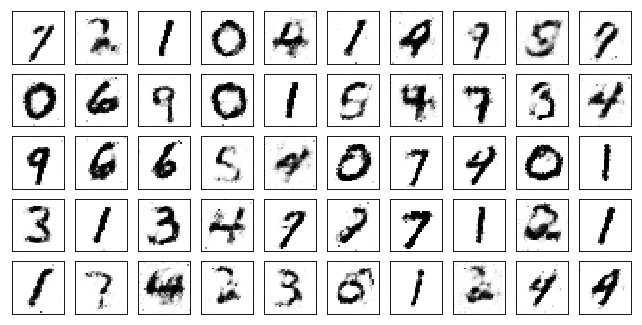

Test losses. G: 1.4101, D: 0.3629
Train Epoch: 35 [0/50000 (0%)]	Losses G: 1.5215, D: 0.3844
Train Epoch: 35 [5000/50000 (10%)]	Losses G: 1.3597, D: 0.5588
Train Epoch: 35 [10000/50000 (20%)]	Losses G: 1.1048, D: 0.5263
Train Epoch: 35 [15000/50000 (30%)]	Losses G: 1.0472, D: 0.5642
Train Epoch: 35 [20000/50000 (40%)]	Losses G: 1.2398, D: 0.4696
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 1.3637, D: 0.5430
Train Epoch: 35 [30000/50000 (60%)]	Losses G: 1.5652, D: 0.4726
Train Epoch: 35 [35000/50000 (70%)]	Losses G: 1.4077, D: 0.4713
Train Epoch: 35 [40000/50000 (80%)]	Losses G: 1.4417, D: 0.4655
Train Epoch: 35 [45000/50000 (90%)]	Losses G: 1.6967, D: 0.5413
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 1.1501, D: 0.6338


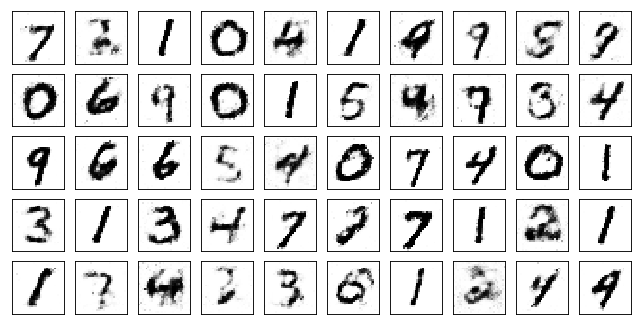

Test losses. G: 1.0390, D: 0.4655
Train Epoch: 36 [0/50000 (0%)]	Losses G: 1.1328, D: 0.5081
Train Epoch: 36 [5000/50000 (10%)]	Losses G: 1.6118, D: 0.4785
Train Epoch: 36 [10000/50000 (20%)]	Losses G: 1.4024, D: 0.5416
Train Epoch: 36 [15000/50000 (30%)]	Losses G: 1.1419, D: 0.6304
Train Epoch: 36 [20000/50000 (40%)]	Losses G: 1.3303, D: 0.4688
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 1.0890, D: 0.5607
Train Epoch: 36 [30000/50000 (60%)]	Losses G: 1.4182, D: 0.4556
Train Epoch: 36 [35000/50000 (70%)]	Losses G: 1.2529, D: 0.5560
Train Epoch: 36 [40000/50000 (80%)]	Losses G: 1.1264, D: 0.5284
Train Epoch: 36 [45000/50000 (90%)]	Losses G: 1.7429, D: 0.4628
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 1.6727, D: 0.5139


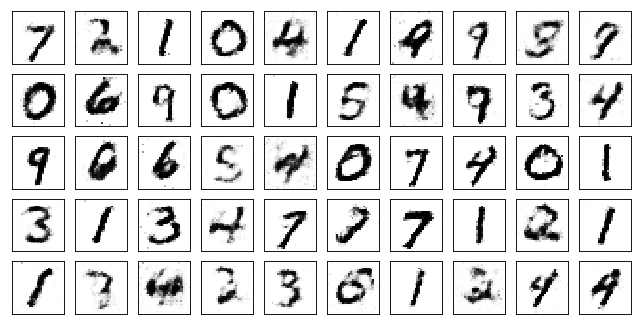

Test losses. G: 1.3667, D: 0.4270
Train Epoch: 37 [0/50000 (0%)]	Losses G: 1.0585, D: 0.5704
Train Epoch: 37 [5000/50000 (10%)]	Losses G: 1.5995, D: 0.5498
Train Epoch: 37 [10000/50000 (20%)]	Losses G: 1.2165, D: 0.5858
Train Epoch: 37 [15000/50000 (30%)]	Losses G: 1.5379, D: 0.5327
Train Epoch: 37 [20000/50000 (40%)]	Losses G: 1.2572, D: 0.5353
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 1.2777, D: 0.5404
Train Epoch: 37 [30000/50000 (60%)]	Losses G: 1.3140, D: 0.5348
Train Epoch: 37 [35000/50000 (70%)]	Losses G: 1.0621, D: 0.4430
Train Epoch: 37 [40000/50000 (80%)]	Losses G: 1.2677, D: 0.5320
Train Epoch: 37 [45000/50000 (90%)]	Losses G: 1.1634, D: 0.5094
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 1.1441, D: 0.4107


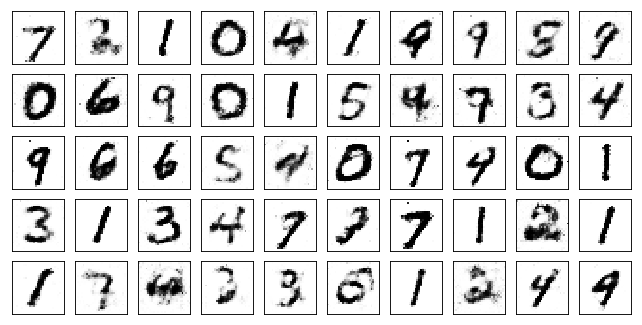

Test losses. G: 1.2885, D: 0.4150
Train Epoch: 38 [0/50000 (0%)]	Losses G: 1.4529, D: 0.5587
Train Epoch: 38 [5000/50000 (10%)]	Losses G: 1.2005, D: 0.5484
Train Epoch: 38 [10000/50000 (20%)]	Losses G: 1.3569, D: 0.5456
Train Epoch: 38 [15000/50000 (30%)]	Losses G: 1.0813, D: 0.5027
Train Epoch: 38 [20000/50000 (40%)]	Losses G: 1.1617, D: 0.4443
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 1.0906, D: 0.5328
Train Epoch: 38 [30000/50000 (60%)]	Losses G: 1.3943, D: 0.4701
Train Epoch: 38 [35000/50000 (70%)]	Losses G: 1.4078, D: 0.5247
Train Epoch: 38 [40000/50000 (80%)]	Losses G: 1.4913, D: 0.4372
Train Epoch: 38 [45000/50000 (90%)]	Losses G: 1.4699, D: 0.4424
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 1.5817, D: 0.4462


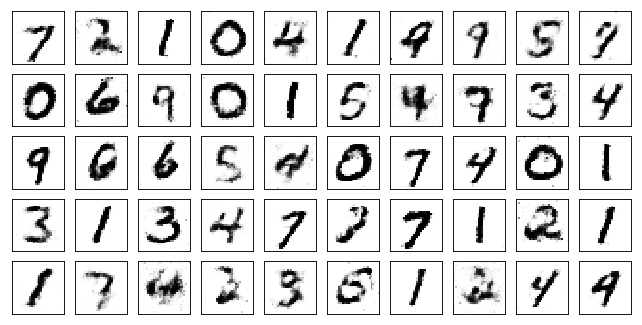

Test losses. G: 1.5247, D: 0.4301
Train Epoch: 39 [0/50000 (0%)]	Losses G: 1.5479, D: 0.4387
Train Epoch: 39 [5000/50000 (10%)]	Losses G: 1.5600, D: 0.5606
Train Epoch: 39 [10000/50000 (20%)]	Losses G: 0.9580, D: 0.5473
Train Epoch: 39 [15000/50000 (30%)]	Losses G: 1.1419, D: 0.4874
Train Epoch: 39 [20000/50000 (40%)]	Losses G: 1.2138, D: 0.6225
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 1.4849, D: 0.4628
Train Epoch: 39 [30000/50000 (60%)]	Losses G: 1.2377, D: 0.5893
Train Epoch: 39 [35000/50000 (70%)]	Losses G: 1.2893, D: 0.6288
Train Epoch: 39 [40000/50000 (80%)]	Losses G: 1.0981, D: 0.5898
Train Epoch: 39 [45000/50000 (90%)]	Losses G: 1.4845, D: 0.4339
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 1.2576, D: 0.5347


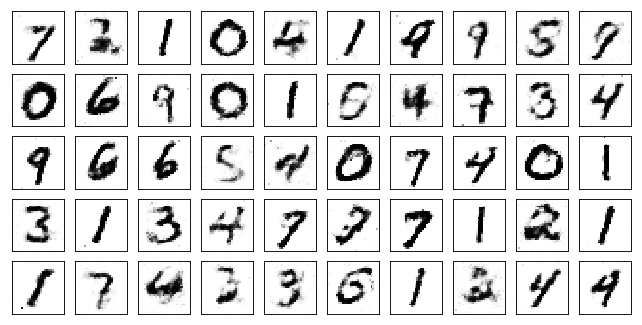

Test losses. G: 1.3157, D: 0.4239
Train Epoch: 40 [0/50000 (0%)]	Losses G: 1.4225, D: 0.5401
Train Epoch: 40 [5000/50000 (10%)]	Losses G: 1.0949, D: 0.5324
Train Epoch: 40 [10000/50000 (20%)]	Losses G: 0.9188, D: 0.5387
Train Epoch: 40 [15000/50000 (30%)]	Losses G: 1.0462, D: 0.5264
Train Epoch: 40 [20000/50000 (40%)]	Losses G: 1.3575, D: 0.5193
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 1.5199, D: 0.4009
Train Epoch: 40 [30000/50000 (60%)]	Losses G: 1.5024, D: 0.4552
Train Epoch: 40 [35000/50000 (70%)]	Losses G: 1.2086, D: 0.5248
Train Epoch: 40 [40000/50000 (80%)]	Losses G: 1.3373, D: 0.5158
Train Epoch: 40 [45000/50000 (90%)]	Losses G: 1.0667, D: 0.5742
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 1.0834, D: 0.5735


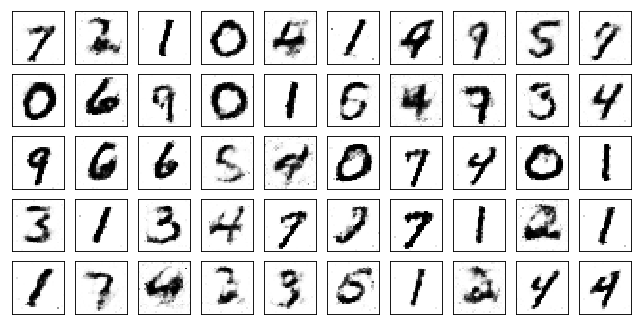

Test losses. G: 1.0892, D: 0.4879
Train Epoch: 41 [0/50000 (0%)]	Losses G: 1.1712, D: 0.6012
Train Epoch: 41 [5000/50000 (10%)]	Losses G: 1.2941, D: 0.4736
Train Epoch: 41 [10000/50000 (20%)]	Losses G: 1.5519, D: 0.4455
Train Epoch: 41 [15000/50000 (30%)]	Losses G: 1.2766, D: 0.5061
Train Epoch: 41 [20000/50000 (40%)]	Losses G: 1.1615, D: 0.5476
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 1.1387, D: 0.5654
Train Epoch: 41 [30000/50000 (60%)]	Losses G: 1.4604, D: 0.5182
Train Epoch: 41 [35000/50000 (70%)]	Losses G: 1.3440, D: 0.4818
Train Epoch: 41 [40000/50000 (80%)]	Losses G: 1.0990, D: 0.5062
Train Epoch: 41 [45000/50000 (90%)]	Losses G: 0.9031, D: 0.5384
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 1.4223, D: 0.5625


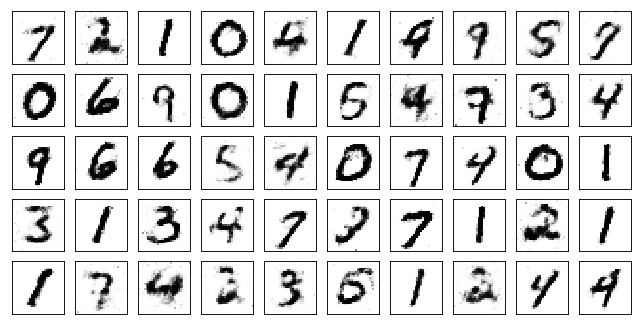

Test losses. G: 1.1861, D: 0.4601
Train Epoch: 42 [0/50000 (0%)]	Losses G: 1.4155, D: 0.4291
Train Epoch: 42 [5000/50000 (10%)]	Losses G: 1.3586, D: 0.5239
Train Epoch: 42 [10000/50000 (20%)]	Losses G: 1.1064, D: 0.4997
Train Epoch: 42 [15000/50000 (30%)]	Losses G: 1.4026, D: 0.4362
Train Epoch: 42 [20000/50000 (40%)]	Losses G: 1.3897, D: 0.5210
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 1.1266, D: 0.4930
Train Epoch: 42 [30000/50000 (60%)]	Losses G: 1.2690, D: 0.5663
Train Epoch: 42 [35000/50000 (70%)]	Losses G: 1.5982, D: 0.4975
Train Epoch: 42 [40000/50000 (80%)]	Losses G: 1.4092, D: 0.5344
Train Epoch: 42 [45000/50000 (90%)]	Losses G: 0.9901, D: 0.5867
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 1.3574, D: 0.5033


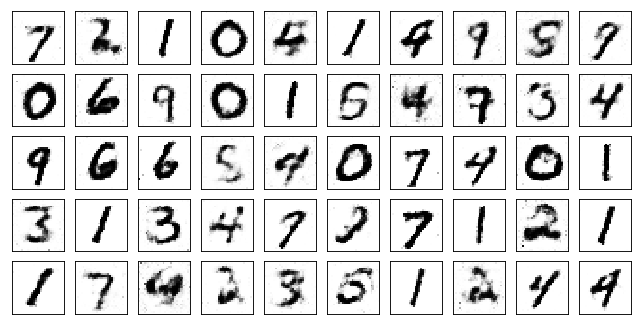

Test losses. G: 1.3036, D: 0.4514
Train Epoch: 43 [0/50000 (0%)]	Losses G: 1.1490, D: 0.5171
Train Epoch: 43 [5000/50000 (10%)]	Losses G: 1.3029, D: 0.4956
Train Epoch: 43 [10000/50000 (20%)]	Losses G: 1.2402, D: 0.6430
Train Epoch: 43 [15000/50000 (30%)]	Losses G: 1.2196, D: 0.6227
Train Epoch: 43 [20000/50000 (40%)]	Losses G: 1.4018, D: 0.5388
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 1.3001, D: 0.4546
Train Epoch: 43 [30000/50000 (60%)]	Losses G: 1.1747, D: 0.5924
Train Epoch: 43 [35000/50000 (70%)]	Losses G: 1.3541, D: 0.4866
Train Epoch: 43 [40000/50000 (80%)]	Losses G: 1.2482, D: 0.4601
Train Epoch: 43 [45000/50000 (90%)]	Losses G: 1.1244, D: 0.5737
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 1.1236, D: 0.5369


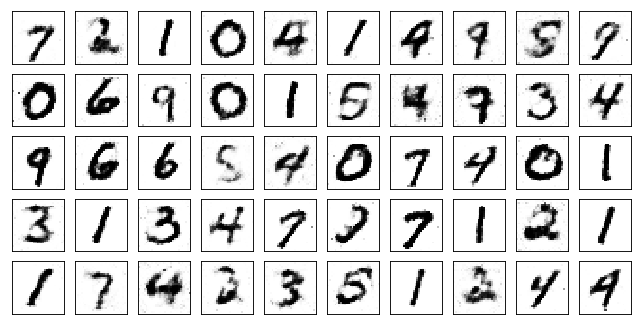

Test losses. G: 1.2060, D: 0.5121
Train Epoch: 44 [0/50000 (0%)]	Losses G: 1.0716, D: 0.7068
Train Epoch: 44 [5000/50000 (10%)]	Losses G: 1.2731, D: 0.4364
Train Epoch: 44 [10000/50000 (20%)]	Losses G: 1.4237, D: 0.5340
Train Epoch: 44 [15000/50000 (30%)]	Losses G: 1.1784, D: 0.5102
Train Epoch: 44 [20000/50000 (40%)]	Losses G: 1.3995, D: 0.5527
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 1.1600, D: 0.4542
Train Epoch: 44 [30000/50000 (60%)]	Losses G: 1.3309, D: 0.4168
Train Epoch: 44 [35000/50000 (70%)]	Losses G: 1.3906, D: 0.5170
Train Epoch: 44 [40000/50000 (80%)]	Losses G: 1.4205, D: 0.4626
Train Epoch: 44 [45000/50000 (90%)]	Losses G: 1.2150, D: 0.5174
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 1.1850, D: 0.4861


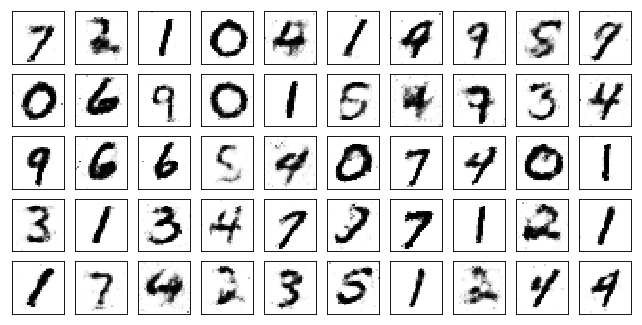

Test losses. G: 1.1732, D: 0.4996
Train Epoch: 45 [0/50000 (0%)]	Losses G: 1.3051, D: 0.5222
Train Epoch: 45 [5000/50000 (10%)]	Losses G: 0.8594, D: 0.5065
Train Epoch: 45 [10000/50000 (20%)]	Losses G: 1.2432, D: 0.4765
Train Epoch: 45 [15000/50000 (30%)]	Losses G: 1.1191, D: 0.5114
Train Epoch: 45 [20000/50000 (40%)]	Losses G: 1.2274, D: 0.5165
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 1.2269, D: 0.4842
Train Epoch: 45 [30000/50000 (60%)]	Losses G: 1.1117, D: 0.5476
Train Epoch: 45 [35000/50000 (70%)]	Losses G: 1.1721, D: 0.5178
Train Epoch: 45 [40000/50000 (80%)]	Losses G: 1.7686, D: 0.5113
Train Epoch: 45 [45000/50000 (90%)]	Losses G: 1.1783, D: 0.5316
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 1.2782, D: 0.5043


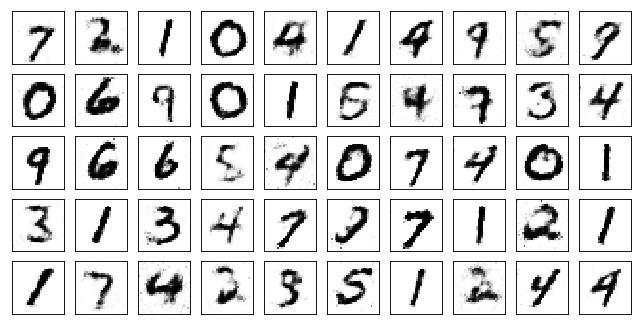

Test losses. G: 1.2530, D: 0.4901
Train Epoch: 46 [0/50000 (0%)]	Losses G: 1.2415, D: 0.6545
Train Epoch: 46 [5000/50000 (10%)]	Losses G: 1.2514, D: 0.5126
Train Epoch: 46 [10000/50000 (20%)]	Losses G: 1.1432, D: 0.5624
Train Epoch: 46 [15000/50000 (30%)]	Losses G: 1.4789, D: 0.5232
Train Epoch: 46 [20000/50000 (40%)]	Losses G: 1.4116, D: 0.5287
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 1.4883, D: 0.4704
Train Epoch: 46 [30000/50000 (60%)]	Losses G: 1.3596, D: 0.4746
Train Epoch: 46 [35000/50000 (70%)]	Losses G: 1.3340, D: 0.5955
Train Epoch: 46 [40000/50000 (80%)]	Losses G: 1.0795, D: 0.5813
Train Epoch: 46 [45000/50000 (90%)]	Losses G: 1.1663, D: 0.5072
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 1.3287, D: 0.5453


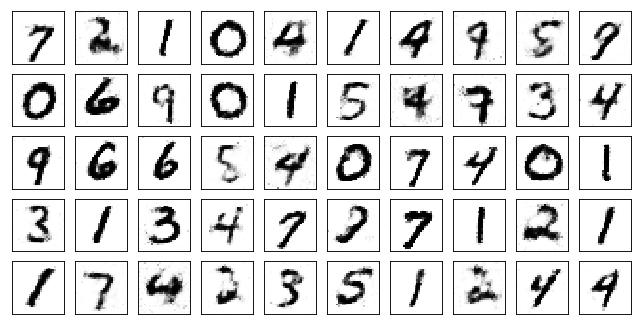

Test losses. G: 1.1557, D: 0.4830
Train Epoch: 47 [0/50000 (0%)]	Losses G: 1.2039, D: 0.5655
Train Epoch: 47 [5000/50000 (10%)]	Losses G: 0.8497, D: 0.5623
Train Epoch: 47 [10000/50000 (20%)]	Losses G: 1.0371, D: 0.5268
Train Epoch: 47 [15000/50000 (30%)]	Losses G: 1.3251, D: 0.4821
Train Epoch: 47 [20000/50000 (40%)]	Losses G: 1.8239, D: 0.5113
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 1.2496, D: 0.5242
Train Epoch: 47 [30000/50000 (60%)]	Losses G: 1.0577, D: 0.5584
Train Epoch: 47 [35000/50000 (70%)]	Losses G: 0.9429, D: 0.4891
Train Epoch: 47 [40000/50000 (80%)]	Losses G: 1.3754, D: 0.4818
Train Epoch: 47 [45000/50000 (90%)]	Losses G: 1.3313, D: 0.4652
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 1.1131, D: 0.5819


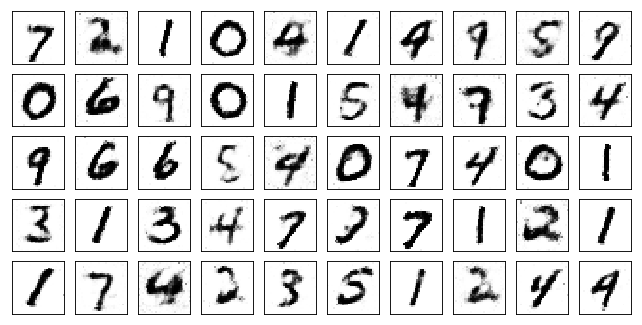

Test losses. G: 0.9960, D: 0.4843
Train Epoch: 48 [0/50000 (0%)]	Losses G: 1.1565, D: 0.5174
Train Epoch: 48 [5000/50000 (10%)]	Losses G: 1.2771, D: 0.5827
Train Epoch: 48 [10000/50000 (20%)]	Losses G: 0.9898, D: 0.6756
Train Epoch: 48 [15000/50000 (30%)]	Losses G: 1.2867, D: 0.5880
Train Epoch: 48 [20000/50000 (40%)]	Losses G: 1.4676, D: 0.5318
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 1.5463, D: 0.4459
Train Epoch: 48 [30000/50000 (60%)]	Losses G: 1.2723, D: 0.4838
Train Epoch: 48 [35000/50000 (70%)]	Losses G: 1.0003, D: 0.5199
Train Epoch: 48 [40000/50000 (80%)]	Losses G: 1.1149, D: 0.6004
Train Epoch: 48 [45000/50000 (90%)]	Losses G: 1.3501, D: 0.6055
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 1.0188, D: 0.5537


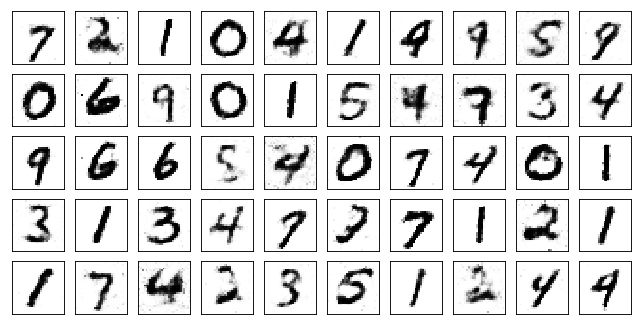

Test losses. G: 1.1341, D: 0.4534
Train Epoch: 49 [0/50000 (0%)]	Losses G: 1.2369, D: 0.5378
Train Epoch: 49 [5000/50000 (10%)]	Losses G: 1.6332, D: 0.4776
Train Epoch: 49 [10000/50000 (20%)]	Losses G: 1.4033, D: 0.4722
Train Epoch: 49 [15000/50000 (30%)]	Losses G: 1.2483, D: 0.5628
Train Epoch: 49 [20000/50000 (40%)]	Losses G: 1.1540, D: 0.5731
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 1.3199, D: 0.5225
Train Epoch: 49 [30000/50000 (60%)]	Losses G: 1.2385, D: 0.5555
Train Epoch: 49 [35000/50000 (70%)]	Losses G: 1.4356, D: 0.5696
Train Epoch: 49 [40000/50000 (80%)]	Losses G: 1.0335, D: 0.5661
Train Epoch: 49 [45000/50000 (90%)]	Losses G: 1.1904, D: 0.4718
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 1.0736, D: 0.5283


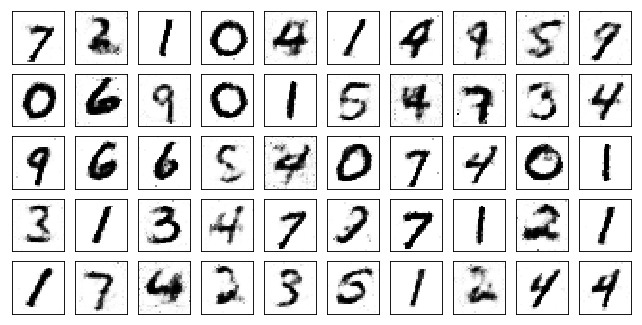

Test losses. G: 1.0707, D: 0.4814
Train Epoch: 50 [0/50000 (0%)]	Losses G: 1.0962, D: 0.5568
Train Epoch: 50 [5000/50000 (10%)]	Losses G: 1.2181, D: 0.5376
Train Epoch: 50 [10000/50000 (20%)]	Losses G: 1.3042, D: 0.5098
Train Epoch: 50 [15000/50000 (30%)]	Losses G: 1.5969, D: 0.5472
Train Epoch: 50 [20000/50000 (40%)]	Losses G: 1.1398, D: 0.5906
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 1.0516, D: 0.5146
Train Epoch: 50 [30000/50000 (60%)]	Losses G: 1.1093, D: 0.5551
Train Epoch: 50 [35000/50000 (70%)]	Losses G: 1.1912, D: 0.5372
Train Epoch: 50 [40000/50000 (80%)]	Losses G: 1.3835, D: 0.4998
Train Epoch: 50 [45000/50000 (90%)]	Losses G: 1.3140, D: 0.6061
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 1.3270, D: 0.5413


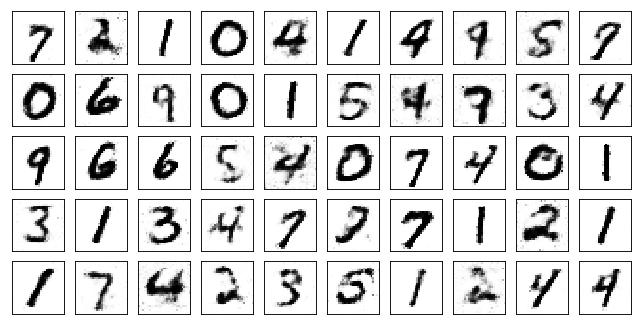

Test losses. G: 1.3993, D: 0.4496
Train Epoch: 51 [0/50000 (0%)]	Losses G: 1.3611, D: 0.4641
Train Epoch: 51 [5000/50000 (10%)]	Losses G: 1.2752, D: 0.5032
Train Epoch: 51 [10000/50000 (20%)]	Losses G: 1.3891, D: 0.5522
Train Epoch: 51 [15000/50000 (30%)]	Losses G: 1.2819, D: 0.4955
Train Epoch: 51 [20000/50000 (40%)]	Losses G: 1.3106, D: 0.4791
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 1.2222, D: 0.4523
Train Epoch: 51 [30000/50000 (60%)]	Losses G: 1.3195, D: 0.5446
Train Epoch: 51 [35000/50000 (70%)]	Losses G: 0.9588, D: 0.5647
Train Epoch: 51 [40000/50000 (80%)]	Losses G: 1.1448, D: 0.4876
Train Epoch: 51 [45000/50000 (90%)]	Losses G: 1.5149, D: 0.3931
Train Epoch: 51 [50000/50000 (100%)]	Losses G: 1.2739, D: 0.4854


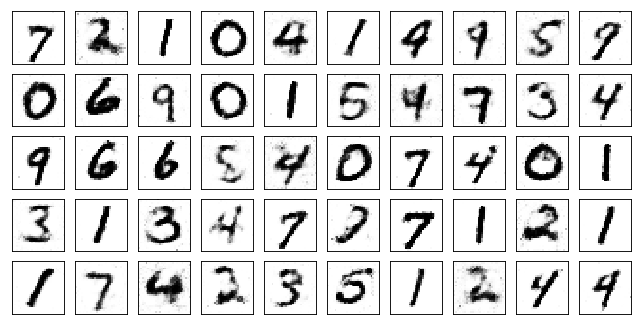

Test losses. G: 1.0495, D: 0.4662
Train Epoch: 52 [0/50000 (0%)]	Losses G: 1.0634, D: 0.4716
Train Epoch: 52 [5000/50000 (10%)]	Losses G: 1.1757, D: 0.4665
Train Epoch: 52 [10000/50000 (20%)]	Losses G: 1.3133, D: 0.5973
Train Epoch: 52 [15000/50000 (30%)]	Losses G: 1.0732, D: 0.5942
Train Epoch: 52 [20000/50000 (40%)]	Losses G: 0.8290, D: 0.6005
Train Epoch: 52 [25000/50000 (50%)]	Losses G: 0.8613, D: 0.5548
Train Epoch: 52 [30000/50000 (60%)]	Losses G: 1.4122, D: 0.5150
Train Epoch: 52 [35000/50000 (70%)]	Losses G: 1.2572, D: 0.4731
Train Epoch: 52 [40000/50000 (80%)]	Losses G: 1.0658, D: 0.5225
Train Epoch: 52 [45000/50000 (90%)]	Losses G: 0.8505, D: 0.5362
Train Epoch: 52 [50000/50000 (100%)]	Losses G: 1.0175, D: 0.5819


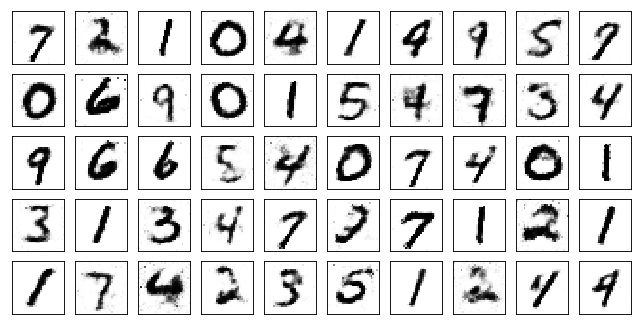

Test losses. G: 0.9043, D: 0.5190
Train Epoch: 53 [0/50000 (0%)]	Losses G: 1.0648, D: 0.6309
Train Epoch: 53 [5000/50000 (10%)]	Losses G: 1.3042, D: 0.5800
Train Epoch: 53 [10000/50000 (20%)]	Losses G: 1.5547, D: 0.4468
Train Epoch: 53 [15000/50000 (30%)]	Losses G: 1.3203, D: 0.5498
Train Epoch: 53 [20000/50000 (40%)]	Losses G: 1.1796, D: 0.5676
Train Epoch: 53 [25000/50000 (50%)]	Losses G: 0.8596, D: 0.5374
Train Epoch: 53 [30000/50000 (60%)]	Losses G: 1.1061, D: 0.5651
Train Epoch: 53 [35000/50000 (70%)]	Losses G: 1.0772, D: 0.5346
Train Epoch: 53 [40000/50000 (80%)]	Losses G: 1.0660, D: 0.5762
Train Epoch: 53 [45000/50000 (90%)]	Losses G: 1.1999, D: 0.5290
Train Epoch: 53 [50000/50000 (100%)]	Losses G: 0.9811, D: 0.5198


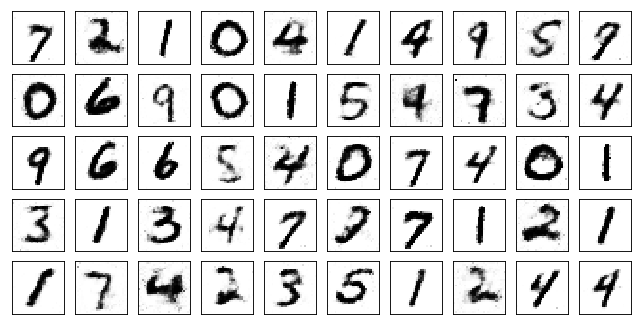

Test losses. G: 1.0824, D: 0.4417
Train Epoch: 54 [0/50000 (0%)]	Losses G: 1.0632, D: 0.5596
Train Epoch: 54 [5000/50000 (10%)]	Losses G: 1.2388, D: 0.4824
Train Epoch: 54 [10000/50000 (20%)]	Losses G: 1.0895, D: 0.5549
Train Epoch: 54 [15000/50000 (30%)]	Losses G: 1.1098, D: 0.5304
Train Epoch: 54 [20000/50000 (40%)]	Losses G: 1.0805, D: 0.5976
Train Epoch: 54 [25000/50000 (50%)]	Losses G: 1.3150, D: 0.6442
Train Epoch: 54 [30000/50000 (60%)]	Losses G: 0.8190, D: 0.5523
Train Epoch: 54 [35000/50000 (70%)]	Losses G: 1.2851, D: 0.5788
Train Epoch: 54 [40000/50000 (80%)]	Losses G: 1.1429, D: 0.4587
Train Epoch: 54 [45000/50000 (90%)]	Losses G: 1.2872, D: 0.4655
Train Epoch: 54 [50000/50000 (100%)]	Losses G: 1.1493, D: 0.4630


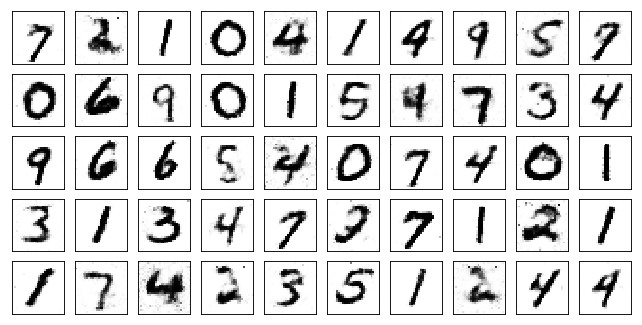

Test losses. G: 1.3203, D: 0.4860
Train Epoch: 55 [0/50000 (0%)]	Losses G: 1.0483, D: 0.4733
Train Epoch: 55 [5000/50000 (10%)]	Losses G: 1.1588, D: 0.6696
Train Epoch: 55 [10000/50000 (20%)]	Losses G: 1.2090, D: 0.5417
Train Epoch: 55 [15000/50000 (30%)]	Losses G: 1.0237, D: 0.5466
Train Epoch: 55 [20000/50000 (40%)]	Losses G: 1.1527, D: 0.6561
Train Epoch: 55 [25000/50000 (50%)]	Losses G: 1.1260, D: 0.4674
Train Epoch: 55 [30000/50000 (60%)]	Losses G: 1.3436, D: 0.6058
Train Epoch: 55 [35000/50000 (70%)]	Losses G: 1.1914, D: 0.5145
Train Epoch: 55 [40000/50000 (80%)]	Losses G: 1.1453, D: 0.5005
Train Epoch: 55 [45000/50000 (90%)]	Losses G: 1.2345, D: 0.5662
Train Epoch: 55 [50000/50000 (100%)]	Losses G: 1.0707, D: 0.4954


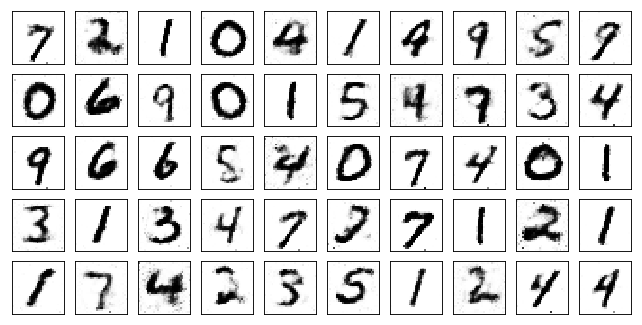

Test losses. G: 1.1738, D: 0.4936
Train Epoch: 56 [0/50000 (0%)]	Losses G: 1.0782, D: 0.6383
Train Epoch: 56 [5000/50000 (10%)]	Losses G: 1.0446, D: 0.5155
Train Epoch: 56 [10000/50000 (20%)]	Losses G: 1.0311, D: 0.5539
Train Epoch: 56 [15000/50000 (30%)]	Losses G: 1.4062, D: 0.5030
Train Epoch: 56 [20000/50000 (40%)]	Losses G: 1.2394, D: 0.5710
Train Epoch: 56 [25000/50000 (50%)]	Losses G: 1.2536, D: 0.5670
Train Epoch: 56 [30000/50000 (60%)]	Losses G: 0.9911, D: 0.5106
Train Epoch: 56 [35000/50000 (70%)]	Losses G: 1.1032, D: 0.6061
Train Epoch: 56 [40000/50000 (80%)]	Losses G: 1.1261, D: 0.5596
Train Epoch: 56 [45000/50000 (90%)]	Losses G: 1.2161, D: 0.5431
Train Epoch: 56 [50000/50000 (100%)]	Losses G: 1.1561, D: 0.5165


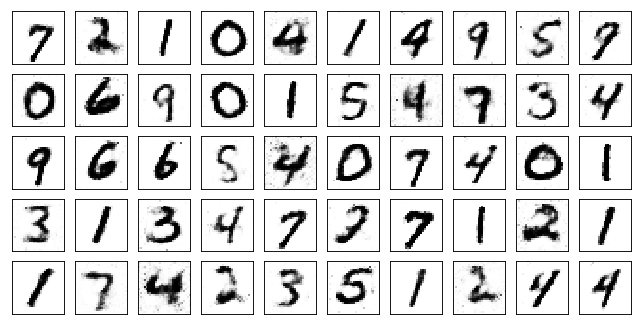

Test losses. G: 1.1451, D: 0.4874
Train Epoch: 57 [0/50000 (0%)]	Losses G: 1.0309, D: 0.4881
Train Epoch: 57 [5000/50000 (10%)]	Losses G: 1.1814, D: 0.5474
Train Epoch: 57 [10000/50000 (20%)]	Losses G: 1.1627, D: 0.5074
Train Epoch: 57 [15000/50000 (30%)]	Losses G: 1.3971, D: 0.5704
Train Epoch: 57 [20000/50000 (40%)]	Losses G: 1.1950, D: 0.5316
Train Epoch: 57 [25000/50000 (50%)]	Losses G: 1.0887, D: 0.5561
Train Epoch: 57 [30000/50000 (60%)]	Losses G: 1.1700, D: 0.5165
Train Epoch: 57 [35000/50000 (70%)]	Losses G: 1.1928, D: 0.6160
Train Epoch: 57 [40000/50000 (80%)]	Losses G: 1.1885, D: 0.5459
Train Epoch: 57 [45000/50000 (90%)]	Losses G: 1.3690, D: 0.5177
Train Epoch: 57 [50000/50000 (100%)]	Losses G: 1.0811, D: 0.6206


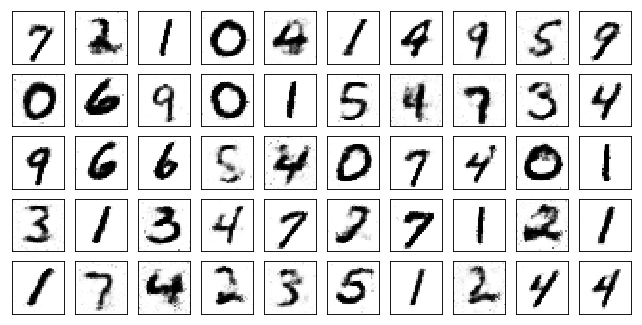

Test losses. G: 1.0360, D: 0.4979
Train Epoch: 58 [0/50000 (0%)]	Losses G: 0.9739, D: 0.5821
Train Epoch: 58 [5000/50000 (10%)]	Losses G: 1.5438, D: 0.4855
Train Epoch: 58 [10000/50000 (20%)]	Losses G: 1.2128, D: 0.5715
Train Epoch: 58 [15000/50000 (30%)]	Losses G: 1.0911, D: 0.4481
Train Epoch: 58 [20000/50000 (40%)]	Losses G: 0.9624, D: 0.5408
Train Epoch: 58 [25000/50000 (50%)]	Losses G: 1.0674, D: 0.5730
Train Epoch: 58 [30000/50000 (60%)]	Losses G: 1.3117, D: 0.5708
Train Epoch: 58 [35000/50000 (70%)]	Losses G: 1.1421, D: 0.6208
Train Epoch: 58 [40000/50000 (80%)]	Losses G: 1.2423, D: 0.5413
Train Epoch: 58 [45000/50000 (90%)]	Losses G: 1.1121, D: 0.4950
Train Epoch: 58 [50000/50000 (100%)]	Losses G: 1.2985, D: 0.5084


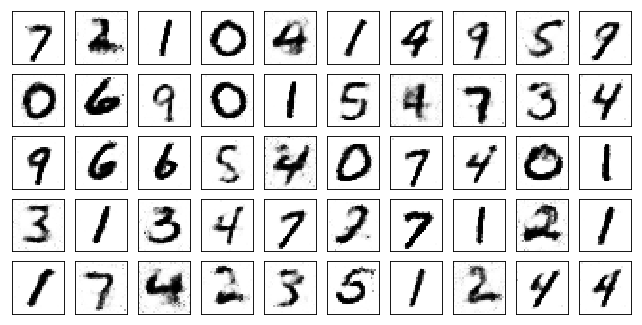

Test losses. G: 1.2556, D: 0.5159
Train Epoch: 59 [0/50000 (0%)]	Losses G: 1.1493, D: 0.5715
Train Epoch: 59 [5000/50000 (10%)]	Losses G: 1.0736, D: 0.6039
Train Epoch: 59 [10000/50000 (20%)]	Losses G: 1.3050, D: 0.6066
Train Epoch: 59 [15000/50000 (30%)]	Losses G: 1.0286, D: 0.6317
Train Epoch: 59 [20000/50000 (40%)]	Losses G: 1.1180, D: 0.5930
Train Epoch: 59 [25000/50000 (50%)]	Losses G: 1.1991, D: 0.5713
Train Epoch: 59 [30000/50000 (60%)]	Losses G: 0.8845, D: 0.4521
Train Epoch: 59 [35000/50000 (70%)]	Losses G: 1.0252, D: 0.5961
Train Epoch: 59 [40000/50000 (80%)]	Losses G: 1.2459, D: 0.5796
Train Epoch: 59 [45000/50000 (90%)]	Losses G: 0.9642, D: 0.6495
Train Epoch: 59 [50000/50000 (100%)]	Losses G: 1.2662, D: 0.5595


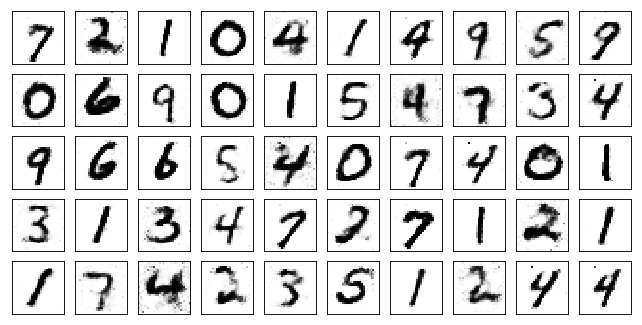

Test losses. G: 1.1478, D: 0.5259
Train Epoch: 60 [0/50000 (0%)]	Losses G: 1.2063, D: 0.5324
Train Epoch: 60 [5000/50000 (10%)]	Losses G: 1.0813, D: 0.6210
Train Epoch: 60 [10000/50000 (20%)]	Losses G: 1.3210, D: 0.4978
Train Epoch: 60 [15000/50000 (30%)]	Losses G: 1.3504, D: 0.5187
Train Epoch: 60 [20000/50000 (40%)]	Losses G: 1.1115, D: 0.5623
Train Epoch: 60 [25000/50000 (50%)]	Losses G: 1.1232, D: 0.5926
Train Epoch: 60 [30000/50000 (60%)]	Losses G: 1.0854, D: 0.5278
Train Epoch: 60 [35000/50000 (70%)]	Losses G: 1.0108, D: 0.5529
Train Epoch: 60 [40000/50000 (80%)]	Losses G: 1.2191, D: 0.5803
Train Epoch: 60 [45000/50000 (90%)]	Losses G: 1.5292, D: 0.5186
Train Epoch: 60 [50000/50000 (100%)]	Losses G: 1.0246, D: 0.5746


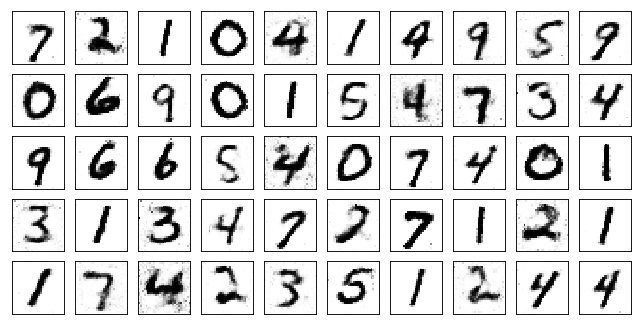

Test losses. G: 0.9374, D: 0.5630
Train Epoch: 61 [0/50000 (0%)]	Losses G: 0.9778, D: 0.5992
Train Epoch: 61 [5000/50000 (10%)]	Losses G: 0.9797, D: 0.6150
Train Epoch: 61 [10000/50000 (20%)]	Losses G: 1.2627, D: 0.5522
Train Epoch: 61 [15000/50000 (30%)]	Losses G: 1.2778, D: 0.6194
Train Epoch: 61 [20000/50000 (40%)]	Losses G: 1.1069, D: 0.4754
Train Epoch: 61 [25000/50000 (50%)]	Losses G: 1.1950, D: 0.5374
Train Epoch: 61 [30000/50000 (60%)]	Losses G: 1.0588, D: 0.5765
Train Epoch: 61 [35000/50000 (70%)]	Losses G: 1.0936, D: 0.5924
Train Epoch: 61 [40000/50000 (80%)]	Losses G: 1.0472, D: 0.6214
Train Epoch: 61 [45000/50000 (90%)]	Losses G: 1.0485, D: 0.6368
Train Epoch: 61 [50000/50000 (100%)]	Losses G: 1.1605, D: 0.5349


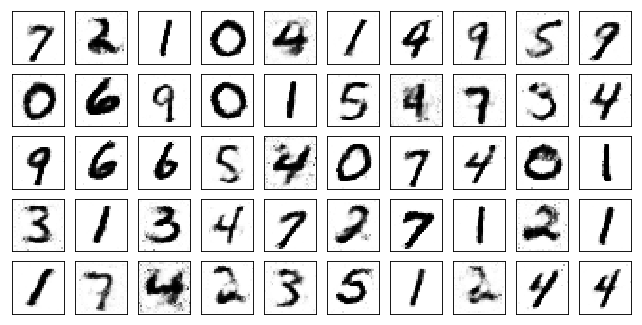

Test losses. G: 1.2115, D: 0.5335
Train Epoch: 62 [0/50000 (0%)]	Losses G: 1.0923, D: 0.6067
Train Epoch: 62 [5000/50000 (10%)]	Losses G: 1.1482, D: 0.5954
Train Epoch: 62 [10000/50000 (20%)]	Losses G: 0.8418, D: 0.5229
Train Epoch: 62 [15000/50000 (30%)]	Losses G: 1.2012, D: 0.5040
Train Epoch: 62 [20000/50000 (40%)]	Losses G: 1.1845, D: 0.5480
Train Epoch: 62 [25000/50000 (50%)]	Losses G: 1.0975, D: 0.5716
Train Epoch: 62 [30000/50000 (60%)]	Losses G: 1.4043, D: 0.5482
Train Epoch: 62 [35000/50000 (70%)]	Losses G: 1.2484, D: 0.5199
Train Epoch: 62 [40000/50000 (80%)]	Losses G: 0.9667, D: 0.6214
Train Epoch: 62 [45000/50000 (90%)]	Losses G: 1.0942, D: 0.5726
Train Epoch: 62 [50000/50000 (100%)]	Losses G: 0.9487, D: 0.5510


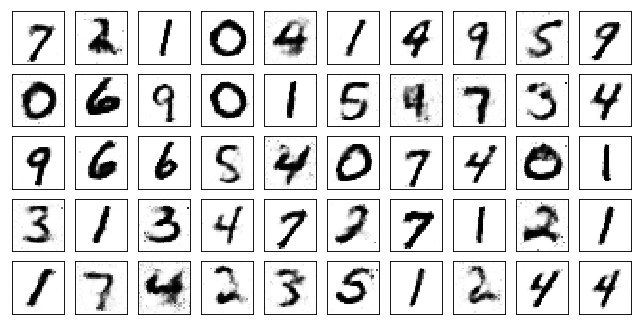

Test losses. G: 1.1477, D: 0.4631
Train Epoch: 63 [0/50000 (0%)]	Losses G: 1.0936, D: 0.4961
Train Epoch: 63 [5000/50000 (10%)]	Losses G: 1.0715, D: 0.5795
Train Epoch: 63 [10000/50000 (20%)]	Losses G: 1.1684, D: 0.5836
Train Epoch: 63 [15000/50000 (30%)]	Losses G: 1.3115, D: 0.5641
Train Epoch: 63 [20000/50000 (40%)]	Losses G: 1.2346, D: 0.4553
Train Epoch: 63 [25000/50000 (50%)]	Losses G: 1.2469, D: 0.5424
Train Epoch: 63 [30000/50000 (60%)]	Losses G: 1.1853, D: 0.5616
Train Epoch: 63 [35000/50000 (70%)]	Losses G: 1.2344, D: 0.5725
Train Epoch: 63 [40000/50000 (80%)]	Losses G: 1.4437, D: 0.5403
Train Epoch: 63 [45000/50000 (90%)]	Losses G: 1.3087, D: 0.5039
Train Epoch: 63 [50000/50000 (100%)]	Losses G: 1.2801, D: 0.5189


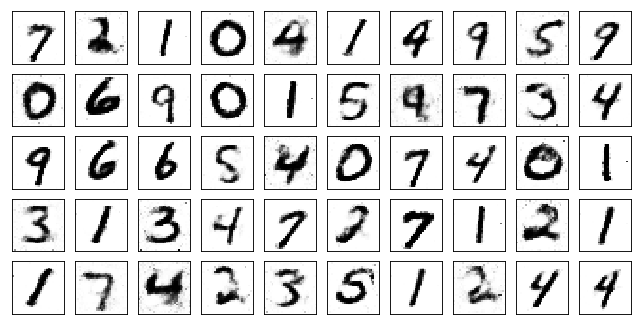

Test losses. G: 1.0572, D: 0.5388
Train Epoch: 64 [0/50000 (0%)]	Losses G: 1.2343, D: 0.6511
Train Epoch: 64 [5000/50000 (10%)]	Losses G: 1.1392, D: 0.5364
Train Epoch: 64 [10000/50000 (20%)]	Losses G: 1.0227, D: 0.5316
Train Epoch: 64 [15000/50000 (30%)]	Losses G: 1.4915, D: 0.5413
Train Epoch: 64 [20000/50000 (40%)]	Losses G: 1.1454, D: 0.5249
Train Epoch: 64 [25000/50000 (50%)]	Losses G: 1.1759, D: 0.4966
Train Epoch: 64 [30000/50000 (60%)]	Losses G: 1.0796, D: 0.5746
Train Epoch: 64 [35000/50000 (70%)]	Losses G: 0.9513, D: 0.6254
Train Epoch: 64 [40000/50000 (80%)]	Losses G: 1.0152, D: 0.6670
Train Epoch: 64 [45000/50000 (90%)]	Losses G: 1.0565, D: 0.5215
Train Epoch: 64 [50000/50000 (100%)]	Losses G: 1.3227, D: 0.5250


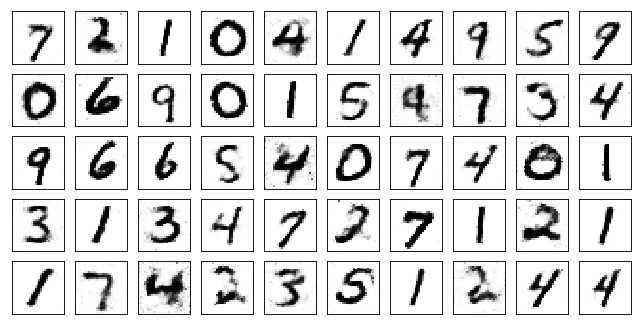

Test losses. G: 1.2756, D: 0.4814
Train Epoch: 65 [0/50000 (0%)]	Losses G: 1.1269, D: 0.5278
Train Epoch: 65 [5000/50000 (10%)]	Losses G: 1.0416, D: 0.6465
Train Epoch: 65 [10000/50000 (20%)]	Losses G: 1.2288, D: 0.6744
Train Epoch: 65 [15000/50000 (30%)]	Losses G: 1.0421, D: 0.6843
Train Epoch: 65 [20000/50000 (40%)]	Losses G: 1.0222, D: 0.6748
Train Epoch: 65 [25000/50000 (50%)]	Losses G: 1.0598, D: 0.6042
Train Epoch: 65 [30000/50000 (60%)]	Losses G: 1.1167, D: 0.5634
Train Epoch: 65 [35000/50000 (70%)]	Losses G: 1.2545, D: 0.5770
Train Epoch: 65 [40000/50000 (80%)]	Losses G: 0.9395, D: 0.5823
Train Epoch: 65 [45000/50000 (90%)]	Losses G: 1.2180, D: 0.6422
Train Epoch: 65 [50000/50000 (100%)]	Losses G: 1.0685, D: 0.5172


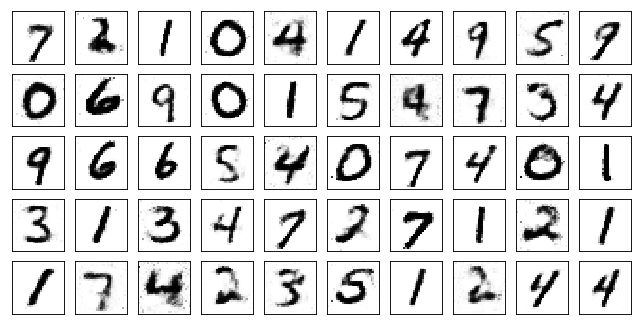

Test losses. G: 1.0287, D: 0.4912
Train Epoch: 66 [0/50000 (0%)]	Losses G: 1.3100, D: 0.5531
Train Epoch: 66 [5000/50000 (10%)]	Losses G: 1.0759, D: 0.4659
Train Epoch: 66 [10000/50000 (20%)]	Losses G: 1.3904, D: 0.4890
Train Epoch: 66 [15000/50000 (30%)]	Losses G: 1.3752, D: 0.5596
Train Epoch: 66 [20000/50000 (40%)]	Losses G: 1.2451, D: 0.5600
Train Epoch: 66 [25000/50000 (50%)]	Losses G: 1.2464, D: 0.5755
Train Epoch: 66 [30000/50000 (60%)]	Losses G: 1.4108, D: 0.5340
Train Epoch: 66 [35000/50000 (70%)]	Losses G: 0.9244, D: 0.5603
Train Epoch: 66 [40000/50000 (80%)]	Losses G: 1.1236, D: 0.5653
Train Epoch: 66 [45000/50000 (90%)]	Losses G: 1.3448, D: 0.4572
Train Epoch: 66 [50000/50000 (100%)]	Losses G: 0.9535, D: 0.6369


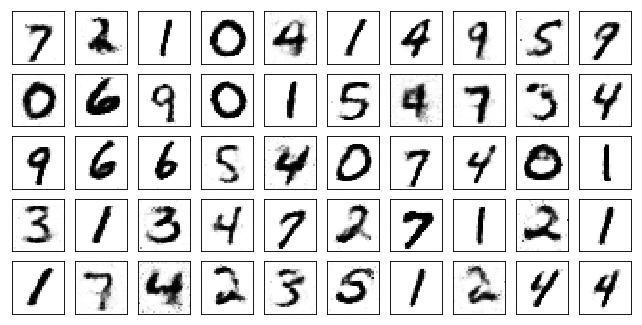

Test losses. G: 0.8465, D: 0.5277
Train Epoch: 67 [0/50000 (0%)]	Losses G: 0.9348, D: 0.6872
Train Epoch: 67 [5000/50000 (10%)]	Losses G: 1.3666, D: 0.5806
Train Epoch: 67 [10000/50000 (20%)]	Losses G: 0.9349, D: 0.4602
Train Epoch: 67 [15000/50000 (30%)]	Losses G: 1.2164, D: 0.6257
Train Epoch: 67 [20000/50000 (40%)]	Losses G: 1.1999, D: 0.5780
Train Epoch: 67 [25000/50000 (50%)]	Losses G: 1.2231, D: 0.5771
Train Epoch: 67 [30000/50000 (60%)]	Losses G: 0.8937, D: 0.6072
Train Epoch: 67 [35000/50000 (70%)]	Losses G: 1.0839, D: 0.5422
Train Epoch: 67 [40000/50000 (80%)]	Losses G: 1.2756, D: 0.5427
Train Epoch: 67 [45000/50000 (90%)]	Losses G: 1.2782, D: 0.5216
Train Epoch: 67 [50000/50000 (100%)]	Losses G: 1.2749, D: 0.5365


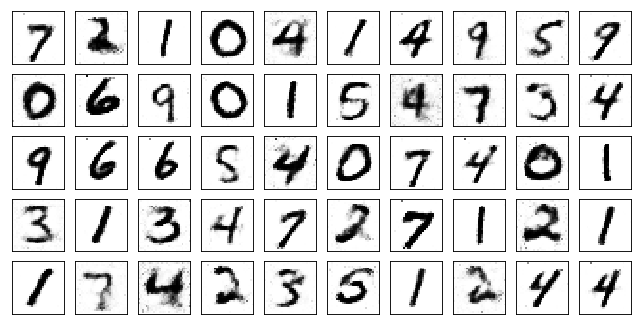

Test losses. G: 1.0788, D: 0.5240
Train Epoch: 68 [0/50000 (0%)]	Losses G: 1.1582, D: 0.5756
Train Epoch: 68 [5000/50000 (10%)]	Losses G: 1.1124, D: 0.5028
Train Epoch: 68 [10000/50000 (20%)]	Losses G: 0.9700, D: 0.6583
Train Epoch: 68 [15000/50000 (30%)]	Losses G: 1.3034, D: 0.5507
Train Epoch: 68 [20000/50000 (40%)]	Losses G: 1.0285, D: 0.5345
Train Epoch: 68 [25000/50000 (50%)]	Losses G: 1.3467, D: 0.6686
Train Epoch: 68 [30000/50000 (60%)]	Losses G: 0.9929, D: 0.5787
Train Epoch: 68 [35000/50000 (70%)]	Losses G: 1.0831, D: 0.5447
Train Epoch: 68 [40000/50000 (80%)]	Losses G: 1.0606, D: 0.6943
Train Epoch: 68 [45000/50000 (90%)]	Losses G: 1.2975, D: 0.5846
Train Epoch: 68 [50000/50000 (100%)]	Losses G: 1.0722, D: 0.6710


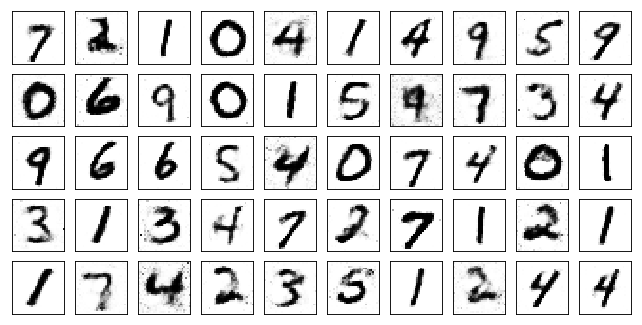

Test losses. G: 0.9588, D: 0.5484
Train Epoch: 69 [0/50000 (0%)]	Losses G: 1.1495, D: 0.5493
Train Epoch: 69 [5000/50000 (10%)]	Losses G: 1.0501, D: 0.5525
Train Epoch: 69 [10000/50000 (20%)]	Losses G: 1.1098, D: 0.5859
Train Epoch: 69 [15000/50000 (30%)]	Losses G: 0.8697, D: 0.6285
Train Epoch: 69 [20000/50000 (40%)]	Losses G: 1.3283, D: 0.5949
Train Epoch: 69 [25000/50000 (50%)]	Losses G: 1.0946, D: 0.6558
Train Epoch: 69 [30000/50000 (60%)]	Losses G: 1.2783, D: 0.5655
Train Epoch: 69 [35000/50000 (70%)]	Losses G: 1.3376, D: 0.5016
Train Epoch: 69 [40000/50000 (80%)]	Losses G: 1.2955, D: 0.5421
Train Epoch: 69 [45000/50000 (90%)]	Losses G: 1.1510, D: 0.5557
Train Epoch: 69 [50000/50000 (100%)]	Losses G: 1.1002, D: 0.5710


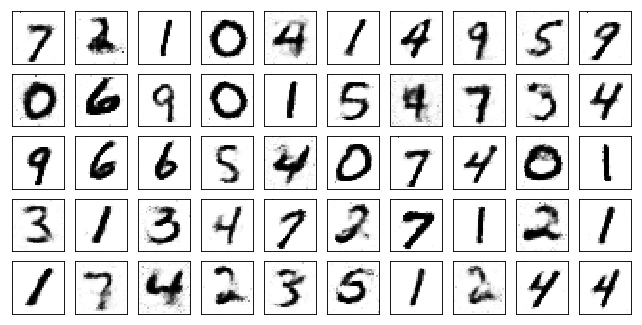

Test losses. G: 0.9435, D: 0.5531
Train Epoch: 70 [0/50000 (0%)]	Losses G: 1.3838, D: 0.5939
Train Epoch: 70 [5000/50000 (10%)]	Losses G: 1.1252, D: 0.6128
Train Epoch: 70 [10000/50000 (20%)]	Losses G: 1.3841, D: 0.5930
Train Epoch: 70 [15000/50000 (30%)]	Losses G: 1.2922, D: 0.5672
Train Epoch: 70 [20000/50000 (40%)]	Losses G: 1.1203, D: 0.5840
Train Epoch: 70 [25000/50000 (50%)]	Losses G: 0.9682, D: 0.6652
Train Epoch: 70 [30000/50000 (60%)]	Losses G: 1.2452, D: 0.6168
Train Epoch: 70 [35000/50000 (70%)]	Losses G: 1.3804, D: 0.5482
Train Epoch: 70 [40000/50000 (80%)]	Losses G: 1.0595, D: 0.5829
Train Epoch: 70 [45000/50000 (90%)]	Losses G: 0.9904, D: 0.5071
Train Epoch: 70 [50000/50000 (100%)]	Losses G: 1.0782, D: 0.6864


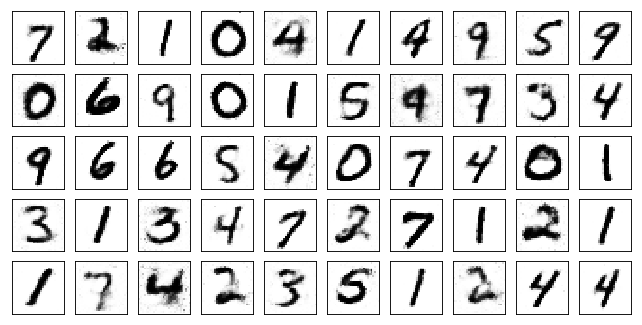

Test losses. G: 1.0578, D: 0.5068
Train Epoch: 71 [0/50000 (0%)]	Losses G: 1.1108, D: 0.5833
Train Epoch: 71 [5000/50000 (10%)]	Losses G: 1.0532, D: 0.5767
Train Epoch: 71 [10000/50000 (20%)]	Losses G: 1.0580, D: 0.5925
Train Epoch: 71 [15000/50000 (30%)]	Losses G: 1.1300, D: 0.6000
Train Epoch: 71 [20000/50000 (40%)]	Losses G: 0.9864, D: 0.6202
Train Epoch: 71 [25000/50000 (50%)]	Losses G: 0.9855, D: 0.5710
Train Epoch: 71 [30000/50000 (60%)]	Losses G: 1.0983, D: 0.5747
Train Epoch: 71 [35000/50000 (70%)]	Losses G: 1.0470, D: 0.5375
Train Epoch: 71 [40000/50000 (80%)]	Losses G: 1.3001, D: 0.5450
Train Epoch: 71 [45000/50000 (90%)]	Losses G: 1.0158, D: 0.5539
Train Epoch: 71 [50000/50000 (100%)]	Losses G: 1.0741, D: 0.5923


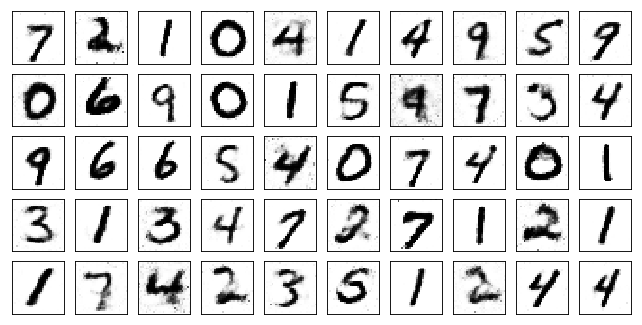

Test losses. G: 0.9650, D: 0.5297
Train Epoch: 72 [0/50000 (0%)]	Losses G: 1.0822, D: 0.5214
Train Epoch: 72 [5000/50000 (10%)]	Losses G: 0.8162, D: 0.5562
Train Epoch: 72 [10000/50000 (20%)]	Losses G: 0.8774, D: 0.6090
Train Epoch: 72 [15000/50000 (30%)]	Losses G: 1.1065, D: 0.6087
Train Epoch: 72 [20000/50000 (40%)]	Losses G: 1.0819, D: 0.5559
Train Epoch: 72 [25000/50000 (50%)]	Losses G: 1.0125, D: 0.6212
Train Epoch: 72 [30000/50000 (60%)]	Losses G: 1.0213, D: 0.5602
Train Epoch: 72 [35000/50000 (70%)]	Losses G: 1.2252, D: 0.5904
Train Epoch: 72 [40000/50000 (80%)]	Losses G: 1.1193, D: 0.5827
Train Epoch: 72 [45000/50000 (90%)]	Losses G: 1.2050, D: 0.6278
Train Epoch: 72 [50000/50000 (100%)]	Losses G: 1.3833, D: 0.6159


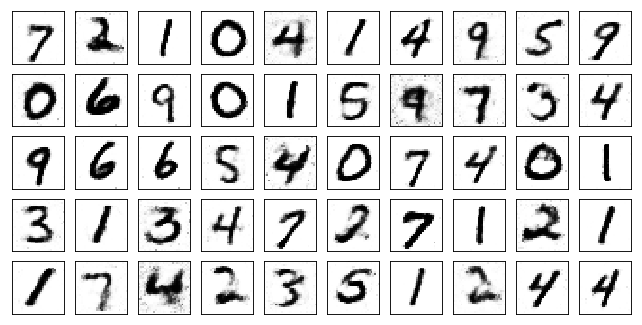

Test losses. G: 1.2148, D: 0.5519
Train Epoch: 73 [0/50000 (0%)]	Losses G: 1.3164, D: 0.5183
Train Epoch: 73 [5000/50000 (10%)]	Losses G: 1.1288, D: 0.5518
Train Epoch: 73 [10000/50000 (20%)]	Losses G: 1.1477, D: 0.4743
Train Epoch: 73 [15000/50000 (30%)]	Losses G: 1.1166, D: 0.7012
Train Epoch: 73 [20000/50000 (40%)]	Losses G: 1.0179, D: 0.5988
Train Epoch: 73 [25000/50000 (50%)]	Losses G: 1.0318, D: 0.5701
Train Epoch: 73 [30000/50000 (60%)]	Losses G: 1.4534, D: 0.5812
Train Epoch: 73 [35000/50000 (70%)]	Losses G: 1.0739, D: 0.6683
Train Epoch: 73 [40000/50000 (80%)]	Losses G: 1.0667, D: 0.5503
Train Epoch: 73 [45000/50000 (90%)]	Losses G: 1.0742, D: 0.6300
Train Epoch: 73 [50000/50000 (100%)]	Losses G: 1.1485, D: 0.5372


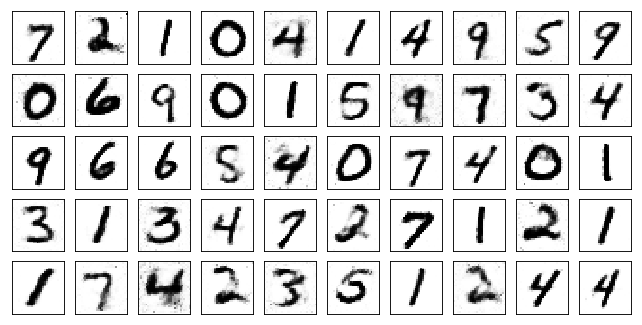

Test losses. G: 1.0622, D: 0.5602
Train Epoch: 74 [0/50000 (0%)]	Losses G: 1.2553, D: 0.6117
Train Epoch: 74 [5000/50000 (10%)]	Losses G: 0.9952, D: 0.5690
Train Epoch: 74 [10000/50000 (20%)]	Losses G: 1.0963, D: 0.5667
Train Epoch: 74 [15000/50000 (30%)]	Losses G: 1.1125, D: 0.6270
Train Epoch: 74 [20000/50000 (40%)]	Losses G: 1.1892, D: 0.5846
Train Epoch: 74 [25000/50000 (50%)]	Losses G: 1.3182, D: 0.4968
Train Epoch: 74 [30000/50000 (60%)]	Losses G: 1.1462, D: 0.6130
Train Epoch: 74 [35000/50000 (70%)]	Losses G: 1.1522, D: 0.5841
Train Epoch: 74 [40000/50000 (80%)]	Losses G: 1.2953, D: 0.4865
Train Epoch: 74 [45000/50000 (90%)]	Losses G: 0.8692, D: 0.4954
Train Epoch: 74 [50000/50000 (100%)]	Losses G: 0.8588, D: 0.5453


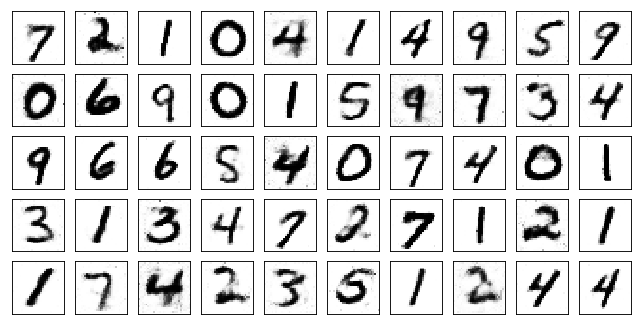

Test losses. G: 0.9984, D: 0.4818
Train Epoch: 75 [0/50000 (0%)]	Losses G: 1.0001, D: 0.5374
Train Epoch: 75 [5000/50000 (10%)]	Losses G: 1.0603, D: 0.5230
Train Epoch: 75 [10000/50000 (20%)]	Losses G: 1.0598, D: 0.6187
Train Epoch: 75 [15000/50000 (30%)]	Losses G: 1.0762, D: 0.5982
Train Epoch: 75 [20000/50000 (40%)]	Losses G: 1.1794, D: 0.6500
Train Epoch: 75 [25000/50000 (50%)]	Losses G: 1.2371, D: 0.6321
Train Epoch: 75 [30000/50000 (60%)]	Losses G: 1.1146, D: 0.5506
Train Epoch: 75 [35000/50000 (70%)]	Losses G: 1.3118, D: 0.5767
Train Epoch: 75 [40000/50000 (80%)]	Losses G: 1.0637, D: 0.5017
Train Epoch: 75 [45000/50000 (90%)]	Losses G: 1.2352, D: 0.5429
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 1.1095, D: 0.4815


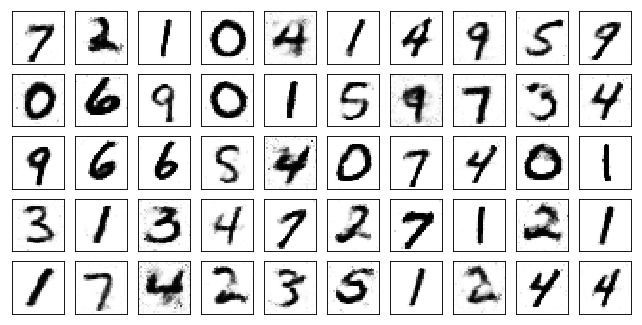

Test losses. G: 1.0031, D: 0.5043
Train Epoch: 76 [0/50000 (0%)]	Losses G: 1.0598, D: 0.5665
Train Epoch: 76 [5000/50000 (10%)]	Losses G: 1.2356, D: 0.6031
Train Epoch: 76 [10000/50000 (20%)]	Losses G: 0.9412, D: 0.5591
Train Epoch: 76 [15000/50000 (30%)]	Losses G: 1.0704, D: 0.5068
Train Epoch: 76 [20000/50000 (40%)]	Losses G: 1.1307, D: 0.5724
Train Epoch: 76 [25000/50000 (50%)]	Losses G: 1.0915, D: 0.5927
Train Epoch: 76 [30000/50000 (60%)]	Losses G: 0.8931, D: 0.6325
Train Epoch: 76 [35000/50000 (70%)]	Losses G: 1.2145, D: 0.5859
Train Epoch: 76 [40000/50000 (80%)]	Losses G: 0.9476, D: 0.5849
Train Epoch: 76 [45000/50000 (90%)]	Losses G: 0.9149, D: 0.5559
Train Epoch: 76 [50000/50000 (100%)]	Losses G: 1.1896, D: 0.5415


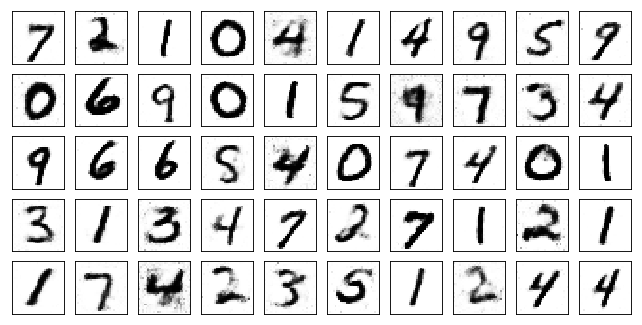

Test losses. G: 0.9898, D: 0.5038
Train Epoch: 77 [0/50000 (0%)]	Losses G: 1.3315, D: 0.6064
Train Epoch: 77 [5000/50000 (10%)]	Losses G: 0.9955, D: 0.5530
Train Epoch: 77 [10000/50000 (20%)]	Losses G: 1.0690, D: 0.5450
Train Epoch: 77 [15000/50000 (30%)]	Losses G: 0.9763, D: 0.5322
Train Epoch: 77 [20000/50000 (40%)]	Losses G: 1.0597, D: 0.5296
Train Epoch: 77 [25000/50000 (50%)]	Losses G: 0.9095, D: 0.5611
Train Epoch: 77 [30000/50000 (60%)]	Losses G: 1.0696, D: 0.5414
Train Epoch: 77 [35000/50000 (70%)]	Losses G: 1.1079, D: 0.6460
Train Epoch: 77 [40000/50000 (80%)]	Losses G: 1.1214, D: 0.5697
Train Epoch: 77 [45000/50000 (90%)]	Losses G: 1.2223, D: 0.5388
Train Epoch: 77 [50000/50000 (100%)]	Losses G: 0.9575, D: 0.6632


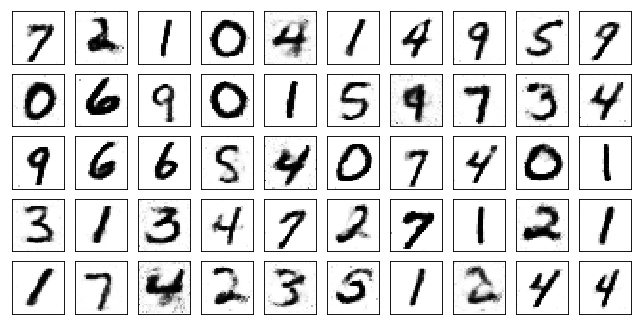

Test losses. G: 1.1247, D: 0.5097
Train Epoch: 78 [0/50000 (0%)]	Losses G: 1.1028, D: 0.5087
Train Epoch: 78 [5000/50000 (10%)]	Losses G: 1.2515, D: 0.6181
Train Epoch: 78 [10000/50000 (20%)]	Losses G: 0.8436, D: 0.6101
Train Epoch: 78 [15000/50000 (30%)]	Losses G: 1.1674, D: 0.5330
Train Epoch: 78 [20000/50000 (40%)]	Losses G: 0.9470, D: 0.6392
Train Epoch: 78 [25000/50000 (50%)]	Losses G: 1.1259, D: 0.6344
Train Epoch: 78 [30000/50000 (60%)]	Losses G: 0.8627, D: 0.7332
Train Epoch: 78 [35000/50000 (70%)]	Losses G: 1.2636, D: 0.5635
Train Epoch: 78 [40000/50000 (80%)]	Losses G: 1.2453, D: 0.5708
Train Epoch: 78 [45000/50000 (90%)]	Losses G: 1.0329, D: 0.6361
Train Epoch: 78 [50000/50000 (100%)]	Losses G: 1.0880, D: 0.5450


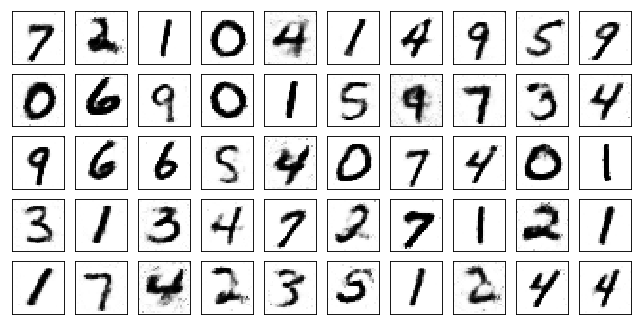

Test losses. G: 1.0879, D: 0.5414
Train Epoch: 79 [0/50000 (0%)]	Losses G: 1.0525, D: 0.5340
Train Epoch: 79 [5000/50000 (10%)]	Losses G: 1.0321, D: 0.5697
Train Epoch: 79 [10000/50000 (20%)]	Losses G: 1.1330, D: 0.5730
Train Epoch: 79 [15000/50000 (30%)]	Losses G: 0.9084, D: 0.5008
Train Epoch: 79 [20000/50000 (40%)]	Losses G: 1.0524, D: 0.5367
Train Epoch: 79 [25000/50000 (50%)]	Losses G: 1.2307, D: 0.6442
Train Epoch: 79 [30000/50000 (60%)]	Losses G: 1.0565, D: 0.6502
Train Epoch: 79 [35000/50000 (70%)]	Losses G: 0.9739, D: 0.5358
Train Epoch: 79 [40000/50000 (80%)]	Losses G: 1.3328, D: 0.5291
Train Epoch: 79 [45000/50000 (90%)]	Losses G: 1.1398, D: 0.5471
Train Epoch: 79 [50000/50000 (100%)]	Losses G: 1.0629, D: 0.5769


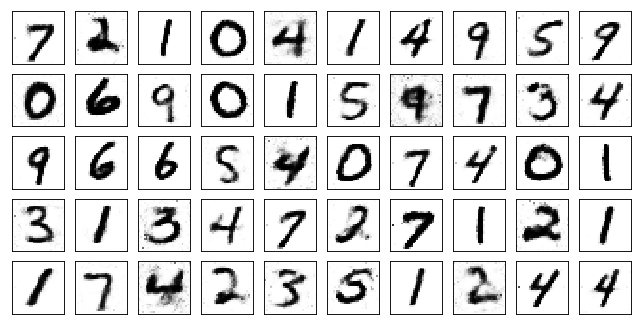

Test losses. G: 1.0127, D: 0.5190
Train Epoch: 80 [0/50000 (0%)]	Losses G: 0.8847, D: 0.5462
Train Epoch: 80 [5000/50000 (10%)]	Losses G: 0.9515, D: 0.6623
Train Epoch: 80 [10000/50000 (20%)]	Losses G: 1.0012, D: 0.5082
Train Epoch: 80 [15000/50000 (30%)]	Losses G: 0.9456, D: 0.4996
Train Epoch: 80 [20000/50000 (40%)]	Losses G: 1.0225, D: 0.5894
Train Epoch: 80 [25000/50000 (50%)]	Losses G: 1.1422, D: 0.5155
Train Epoch: 80 [30000/50000 (60%)]	Losses G: 1.2197, D: 0.6009
Train Epoch: 80 [35000/50000 (70%)]	Losses G: 1.0135, D: 0.6282
Train Epoch: 80 [40000/50000 (80%)]	Losses G: 1.2031, D: 0.5985
Train Epoch: 80 [45000/50000 (90%)]	Losses G: 1.0821, D: 0.4909
Train Epoch: 80 [50000/50000 (100%)]	Losses G: 1.1044, D: 0.5968


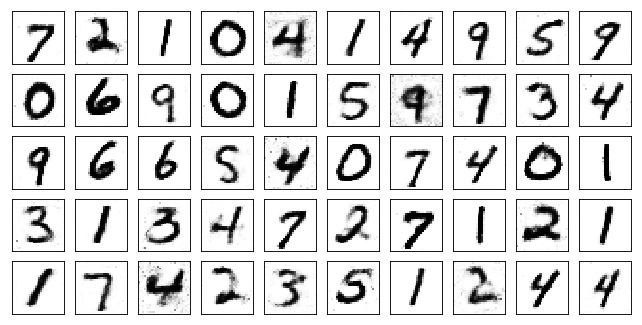

Test losses. G: 1.0405, D: 0.5281
Train Epoch: 81 [0/50000 (0%)]	Losses G: 1.1257, D: 0.5174
Train Epoch: 81 [5000/50000 (10%)]	Losses G: 1.0134, D: 0.6141
Train Epoch: 81 [10000/50000 (20%)]	Losses G: 1.0465, D: 0.6316
Train Epoch: 81 [15000/50000 (30%)]	Losses G: 0.9123, D: 0.6199
Train Epoch: 81 [20000/50000 (40%)]	Losses G: 1.1860, D: 0.5648
Train Epoch: 81 [25000/50000 (50%)]	Losses G: 1.2005, D: 0.6177
Train Epoch: 81 [30000/50000 (60%)]	Losses G: 1.2108, D: 0.6003
Train Epoch: 81 [35000/50000 (70%)]	Losses G: 1.0491, D: 0.4542
Train Epoch: 81 [40000/50000 (80%)]	Losses G: 1.0957, D: 0.5517
Train Epoch: 81 [45000/50000 (90%)]	Losses G: 1.0747, D: 0.5076
Train Epoch: 81 [50000/50000 (100%)]	Losses G: 1.0553, D: 0.5979


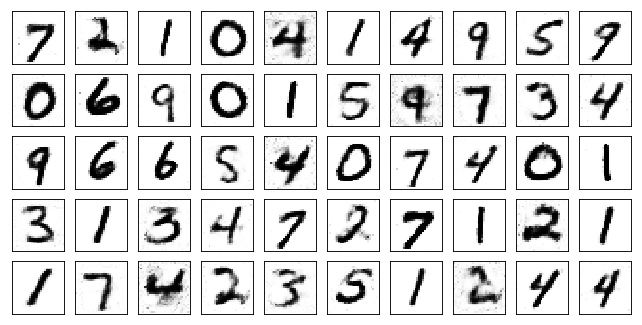

Test losses. G: 1.1134, D: 0.4874
Train Epoch: 82 [0/50000 (0%)]	Losses G: 1.2102, D: 0.5364
Train Epoch: 82 [5000/50000 (10%)]	Losses G: 1.0204, D: 0.5922
Train Epoch: 82 [10000/50000 (20%)]	Losses G: 1.0552, D: 0.5044
Train Epoch: 82 [15000/50000 (30%)]	Losses G: 0.9530, D: 0.5490
Train Epoch: 82 [20000/50000 (40%)]	Losses G: 0.9898, D: 0.6422
Train Epoch: 82 [25000/50000 (50%)]	Losses G: 0.8979, D: 0.5971
Train Epoch: 82 [30000/50000 (60%)]	Losses G: 1.0544, D: 0.6194
Train Epoch: 82 [35000/50000 (70%)]	Losses G: 1.0645, D: 0.6084
Train Epoch: 82 [40000/50000 (80%)]	Losses G: 1.0942, D: 0.5829
Train Epoch: 82 [45000/50000 (90%)]	Losses G: 1.0817, D: 0.6164
Train Epoch: 82 [50000/50000 (100%)]	Losses G: 1.0350, D: 0.6590


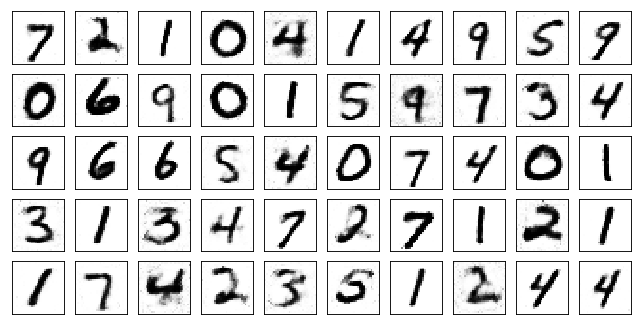

Test losses. G: 1.0362, D: 0.5417
Train Epoch: 83 [0/50000 (0%)]	Losses G: 0.9857, D: 0.5625
Train Epoch: 83 [5000/50000 (10%)]	Losses G: 1.1583, D: 0.6221
Train Epoch: 83 [10000/50000 (20%)]	Losses G: 1.0757, D: 0.5422
Train Epoch: 83 [15000/50000 (30%)]	Losses G: 1.1187, D: 0.5185
Train Epoch: 83 [20000/50000 (40%)]	Losses G: 0.9409, D: 0.5593
Train Epoch: 83 [25000/50000 (50%)]	Losses G: 1.3884, D: 0.5077
Train Epoch: 83 [30000/50000 (60%)]	Losses G: 1.1819, D: 0.5567
Train Epoch: 83 [35000/50000 (70%)]	Losses G: 1.0261, D: 0.6027
Train Epoch: 83 [40000/50000 (80%)]	Losses G: 1.2910, D: 0.5713
Train Epoch: 83 [45000/50000 (90%)]	Losses G: 1.1213, D: 0.5254
Train Epoch: 83 [50000/50000 (100%)]	Losses G: 1.1446, D: 0.5124


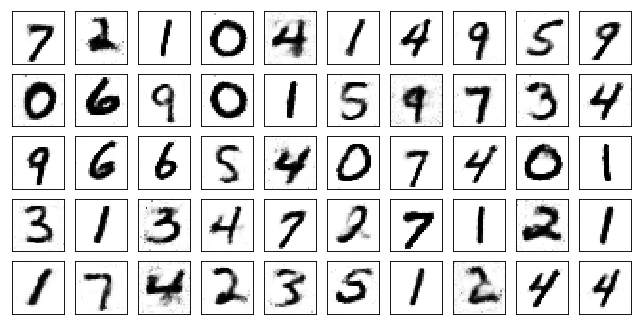

Test losses. G: 1.1026, D: 0.5337
Train Epoch: 84 [0/50000 (0%)]	Losses G: 1.1874, D: 0.6217
Train Epoch: 84 [5000/50000 (10%)]	Losses G: 0.9156, D: 0.5751
Train Epoch: 84 [10000/50000 (20%)]	Losses G: 1.0202, D: 0.5791
Train Epoch: 84 [15000/50000 (30%)]	Losses G: 0.9950, D: 0.6006
Train Epoch: 84 [20000/50000 (40%)]	Losses G: 1.0872, D: 0.5461
Train Epoch: 84 [25000/50000 (50%)]	Losses G: 1.1578, D: 0.6828
Train Epoch: 84 [30000/50000 (60%)]	Losses G: 0.9932, D: 0.6341
Train Epoch: 84 [35000/50000 (70%)]	Losses G: 1.4096, D: 0.5913
Train Epoch: 84 [40000/50000 (80%)]	Losses G: 1.0419, D: 0.5385
Train Epoch: 84 [45000/50000 (90%)]	Losses G: 1.1345, D: 0.5962
Train Epoch: 84 [50000/50000 (100%)]	Losses G: 1.3526, D: 0.5407


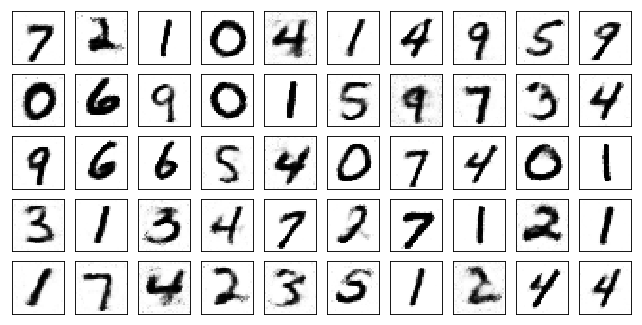

Test losses. G: 1.1027, D: 0.5363
Train Epoch: 85 [0/50000 (0%)]	Losses G: 1.3639, D: 0.5042
Train Epoch: 85 [5000/50000 (10%)]	Losses G: 0.9500, D: 0.5823
Train Epoch: 85 [10000/50000 (20%)]	Losses G: 0.9661, D: 0.5896
Train Epoch: 85 [15000/50000 (30%)]	Losses G: 1.0118, D: 0.6089
Train Epoch: 85 [20000/50000 (40%)]	Losses G: 0.9737, D: 0.5437
Train Epoch: 85 [25000/50000 (50%)]	Losses G: 1.0869, D: 0.6855
Train Epoch: 85 [30000/50000 (60%)]	Losses G: 1.0293, D: 0.5356
Train Epoch: 85 [35000/50000 (70%)]	Losses G: 1.0434, D: 0.5572
Train Epoch: 85 [40000/50000 (80%)]	Losses G: 1.1447, D: 0.6302
Train Epoch: 85 [45000/50000 (90%)]	Losses G: 0.9826, D: 0.6408
Train Epoch: 85 [50000/50000 (100%)]	Losses G: 0.9789, D: 0.5405


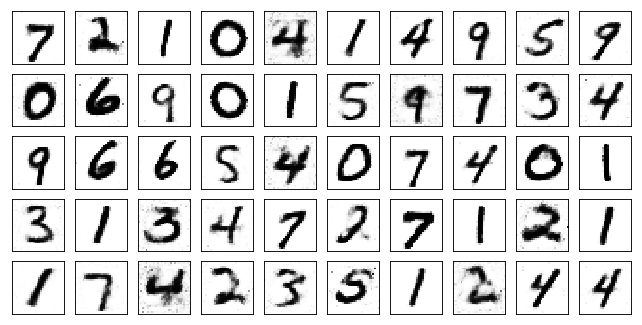

Test losses. G: 0.8804, D: 0.5514
Train Epoch: 86 [0/50000 (0%)]	Losses G: 0.9671, D: 0.5947
Train Epoch: 86 [5000/50000 (10%)]	Losses G: 1.2555, D: 0.5628
Train Epoch: 86 [10000/50000 (20%)]	Losses G: 1.0199, D: 0.5645
Train Epoch: 86 [15000/50000 (30%)]	Losses G: 1.0412, D: 0.5475
Train Epoch: 86 [20000/50000 (40%)]	Losses G: 1.1511, D: 0.5224
Train Epoch: 86 [25000/50000 (50%)]	Losses G: 0.9657, D: 0.5399
Train Epoch: 86 [30000/50000 (60%)]	Losses G: 1.0907, D: 0.5585
Train Epoch: 86 [35000/50000 (70%)]	Losses G: 1.0944, D: 0.5756
Train Epoch: 86 [40000/50000 (80%)]	Losses G: 1.1153, D: 0.5827
Train Epoch: 86 [45000/50000 (90%)]	Losses G: 1.2285, D: 0.5965
Train Epoch: 86 [50000/50000 (100%)]	Losses G: 0.9129, D: 0.5865


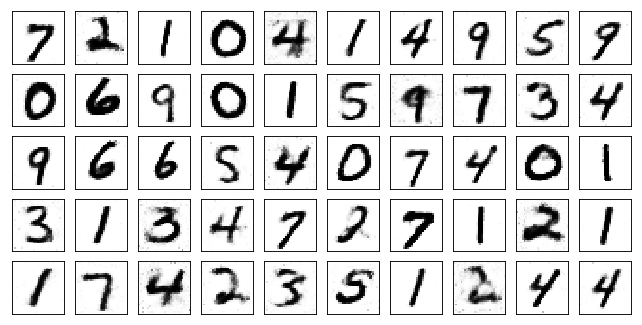

Test losses. G: 1.2032, D: 0.5332
Train Epoch: 87 [0/50000 (0%)]	Losses G: 1.1432, D: 0.5208
Train Epoch: 87 [5000/50000 (10%)]	Losses G: 1.1471, D: 0.5793
Train Epoch: 87 [10000/50000 (20%)]	Losses G: 1.1735, D: 0.6640
Train Epoch: 87 [15000/50000 (30%)]	Losses G: 1.0590, D: 0.5579
Train Epoch: 87 [20000/50000 (40%)]	Losses G: 1.1910, D: 0.5767
Train Epoch: 87 [25000/50000 (50%)]	Losses G: 1.1041, D: 0.5356
Train Epoch: 87 [30000/50000 (60%)]	Losses G: 1.0899, D: 0.6054
Train Epoch: 87 [35000/50000 (70%)]	Losses G: 0.9755, D: 0.5122
Train Epoch: 87 [40000/50000 (80%)]	Losses G: 1.0791, D: 0.5478
Train Epoch: 87 [45000/50000 (90%)]	Losses G: 1.3025, D: 0.5443
Train Epoch: 87 [50000/50000 (100%)]	Losses G: 1.0602, D: 0.4594


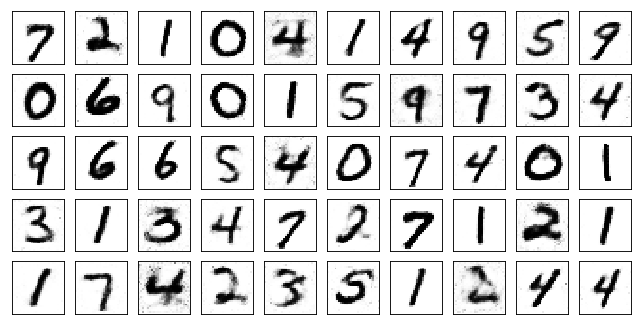

Test losses. G: 1.0997, D: 0.5429
Train Epoch: 88 [0/50000 (0%)]	Losses G: 1.1410, D: 0.5992
Train Epoch: 88 [5000/50000 (10%)]	Losses G: 0.8643, D: 0.6157
Train Epoch: 88 [10000/50000 (20%)]	Losses G: 0.9216, D: 0.5875
Train Epoch: 88 [15000/50000 (30%)]	Losses G: 0.8153, D: 0.6112
Train Epoch: 88 [20000/50000 (40%)]	Losses G: 1.2452, D: 0.5770
Train Epoch: 88 [25000/50000 (50%)]	Losses G: 1.0078, D: 0.5937
Train Epoch: 88 [30000/50000 (60%)]	Losses G: 1.0025, D: 0.5488
Train Epoch: 88 [35000/50000 (70%)]	Losses G: 1.1541, D: 0.5598
Train Epoch: 88 [40000/50000 (80%)]	Losses G: 1.1451, D: 0.5834
Train Epoch: 88 [45000/50000 (90%)]	Losses G: 1.0303, D: 0.5480
Train Epoch: 88 [50000/50000 (100%)]	Losses G: 1.0634, D: 0.4899


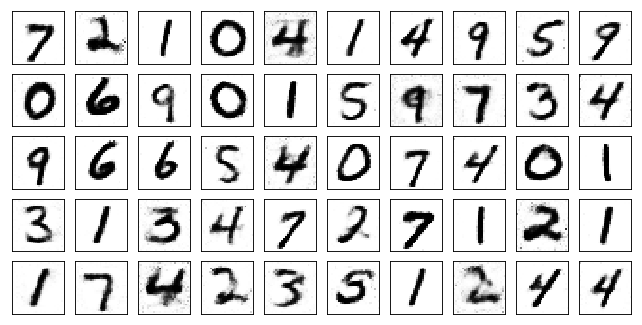

Test losses. G: 1.0338, D: 0.5105
Train Epoch: 89 [0/50000 (0%)]	Losses G: 1.0176, D: 0.5093
Train Epoch: 89 [5000/50000 (10%)]	Losses G: 1.1894, D: 0.5910
Train Epoch: 89 [10000/50000 (20%)]	Losses G: 0.9967, D: 0.5434
Train Epoch: 89 [15000/50000 (30%)]	Losses G: 1.1648, D: 0.5345
Train Epoch: 89 [20000/50000 (40%)]	Losses G: 1.0403, D: 0.6501
Train Epoch: 89 [25000/50000 (50%)]	Losses G: 1.1204, D: 0.6301
Train Epoch: 89 [30000/50000 (60%)]	Losses G: 0.8940, D: 0.6327
Train Epoch: 89 [35000/50000 (70%)]	Losses G: 1.0260, D: 0.6101
Train Epoch: 89 [40000/50000 (80%)]	Losses G: 0.7712, D: 0.5730
Train Epoch: 89 [45000/50000 (90%)]	Losses G: 1.0921, D: 0.6181
Train Epoch: 89 [50000/50000 (100%)]	Losses G: 0.8246, D: 0.6683


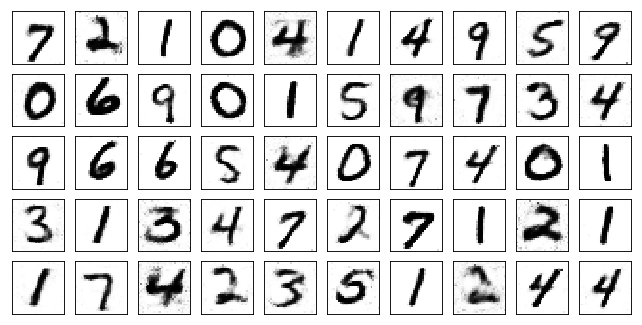

Test losses. G: 0.9156, D: 0.5386
Train Epoch: 90 [0/50000 (0%)]	Losses G: 1.0947, D: 0.5670
Train Epoch: 90 [5000/50000 (10%)]	Losses G: 1.0431, D: 0.5925
Train Epoch: 90 [10000/50000 (20%)]	Losses G: 0.9879, D: 0.6765
Train Epoch: 90 [15000/50000 (30%)]	Losses G: 1.0221, D: 0.6331
Train Epoch: 90 [20000/50000 (40%)]	Losses G: 1.0115, D: 0.5661
Train Epoch: 90 [25000/50000 (50%)]	Losses G: 0.9232, D: 0.5954
Train Epoch: 90 [30000/50000 (60%)]	Losses G: 1.2302, D: 0.6175
Train Epoch: 90 [35000/50000 (70%)]	Losses G: 0.9941, D: 0.6802
Train Epoch: 90 [40000/50000 (80%)]	Losses G: 0.9237, D: 0.6851
Train Epoch: 90 [45000/50000 (90%)]	Losses G: 0.9675, D: 0.5548
Train Epoch: 90 [50000/50000 (100%)]	Losses G: 1.2234, D: 0.6122


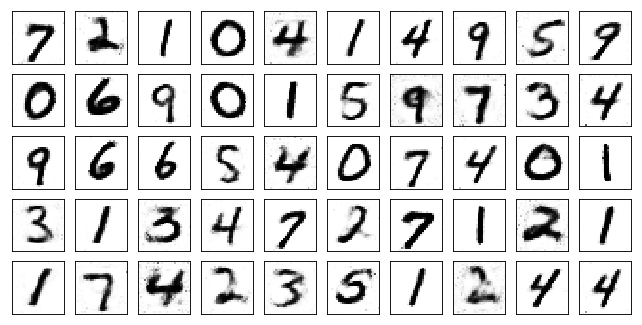

Test losses. G: 1.1114, D: 0.5458
Train Epoch: 91 [0/50000 (0%)]	Losses G: 0.9881, D: 0.6274
Train Epoch: 91 [5000/50000 (10%)]	Losses G: 1.0899, D: 0.5588
Train Epoch: 91 [10000/50000 (20%)]	Losses G: 1.3203, D: 0.5990
Train Epoch: 91 [15000/50000 (30%)]	Losses G: 1.1494, D: 0.4358
Train Epoch: 91 [20000/50000 (40%)]	Losses G: 1.1166, D: 0.5540
Train Epoch: 91 [25000/50000 (50%)]	Losses G: 1.0221, D: 0.5354
Train Epoch: 91 [30000/50000 (60%)]	Losses G: 1.1067, D: 0.6084
Train Epoch: 91 [35000/50000 (70%)]	Losses G: 1.0782, D: 0.5752
Train Epoch: 91 [40000/50000 (80%)]	Losses G: 1.0586, D: 0.6041
Train Epoch: 91 [45000/50000 (90%)]	Losses G: 1.0741, D: 0.5889
Train Epoch: 91 [50000/50000 (100%)]	Losses G: 1.2022, D: 0.5292


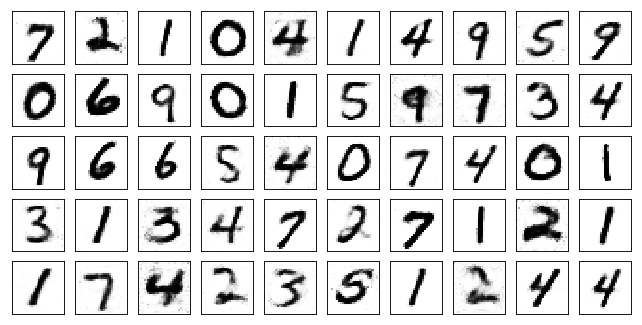

Test losses. G: 1.0400, D: 0.5219
Train Epoch: 92 [0/50000 (0%)]	Losses G: 1.1960, D: 0.5783
Train Epoch: 92 [5000/50000 (10%)]	Losses G: 1.1828, D: 0.5984
Train Epoch: 92 [10000/50000 (20%)]	Losses G: 1.0430, D: 0.5752
Train Epoch: 92 [15000/50000 (30%)]	Losses G: 1.1829, D: 0.5344
Train Epoch: 92 [20000/50000 (40%)]	Losses G: 0.9559, D: 0.5722
Train Epoch: 92 [25000/50000 (50%)]	Losses G: 1.0872, D: 0.5780
Train Epoch: 92 [30000/50000 (60%)]	Losses G: 1.1692, D: 0.6015
Train Epoch: 92 [35000/50000 (70%)]	Losses G: 0.9819, D: 0.6350
Train Epoch: 92 [40000/50000 (80%)]	Losses G: 1.1421, D: 0.6288
Train Epoch: 92 [45000/50000 (90%)]	Losses G: 1.0402, D: 0.6298
Train Epoch: 92 [50000/50000 (100%)]	Losses G: 1.0674, D: 0.5766


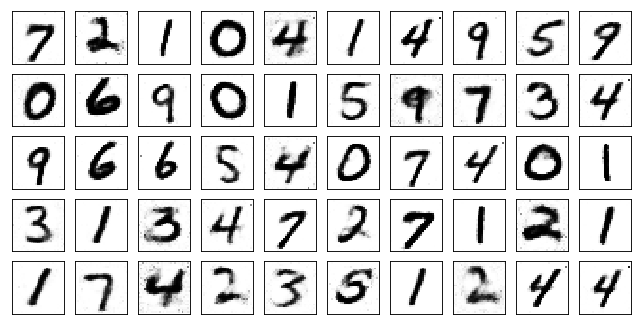

Test losses. G: 0.9731, D: 0.5323
Train Epoch: 93 [0/50000 (0%)]	Losses G: 1.2005, D: 0.6016
Train Epoch: 93 [5000/50000 (10%)]	Losses G: 1.1119, D: 0.5691
Train Epoch: 93 [10000/50000 (20%)]	Losses G: 0.9463, D: 0.5593
Train Epoch: 93 [15000/50000 (30%)]	Losses G: 1.0518, D: 0.5546
Train Epoch: 93 [20000/50000 (40%)]	Losses G: 0.9644, D: 0.5552
Train Epoch: 93 [25000/50000 (50%)]	Losses G: 0.9751, D: 0.5714
Train Epoch: 93 [30000/50000 (60%)]	Losses G: 1.0554, D: 0.5574
Train Epoch: 93 [35000/50000 (70%)]	Losses G: 0.9363, D: 0.5876
Train Epoch: 93 [40000/50000 (80%)]	Losses G: 1.1486, D: 0.5001
Train Epoch: 93 [45000/50000 (90%)]	Losses G: 1.1395, D: 0.5409
Train Epoch: 93 [50000/50000 (100%)]	Losses G: 0.9578, D: 0.6009


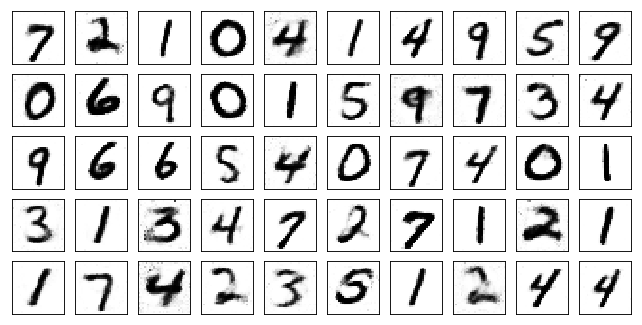

Test losses. G: 1.0294, D: 0.5226
Train Epoch: 94 [0/50000 (0%)]	Losses G: 0.9124, D: 0.5533
Train Epoch: 94 [5000/50000 (10%)]	Losses G: 1.0394, D: 0.5620
Train Epoch: 94 [10000/50000 (20%)]	Losses G: 1.1889, D: 0.6485
Train Epoch: 94 [15000/50000 (30%)]	Losses G: 1.0734, D: 0.6397
Train Epoch: 94 [20000/50000 (40%)]	Losses G: 0.9625, D: 0.5812
Train Epoch: 94 [25000/50000 (50%)]	Losses G: 1.3152, D: 0.4790
Train Epoch: 94 [30000/50000 (60%)]	Losses G: 1.2955, D: 0.6051
Train Epoch: 94 [35000/50000 (70%)]	Losses G: 1.2256, D: 0.5655
Train Epoch: 94 [40000/50000 (80%)]	Losses G: 1.1620, D: 0.5574
Train Epoch: 94 [45000/50000 (90%)]	Losses G: 1.0263, D: 0.5966
Train Epoch: 94 [50000/50000 (100%)]	Losses G: 1.0248, D: 0.5784


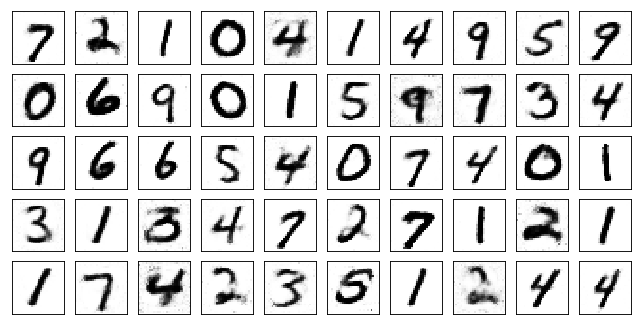

Test losses. G: 1.0134, D: 0.5439
Train Epoch: 95 [0/50000 (0%)]	Losses G: 1.0289, D: 0.6576
Train Epoch: 95 [5000/50000 (10%)]	Losses G: 1.0566, D: 0.5795
Train Epoch: 95 [10000/50000 (20%)]	Losses G: 1.0593, D: 0.5954
Train Epoch: 95 [15000/50000 (30%)]	Losses G: 0.9193, D: 0.6185
Train Epoch: 95 [20000/50000 (40%)]	Losses G: 1.0415, D: 0.6269
Train Epoch: 95 [25000/50000 (50%)]	Losses G: 1.1802, D: 0.5646
Train Epoch: 95 [30000/50000 (60%)]	Losses G: 1.0588, D: 0.5379
Train Epoch: 95 [35000/50000 (70%)]	Losses G: 0.9201, D: 0.6037
Train Epoch: 95 [40000/50000 (80%)]	Losses G: 0.9320, D: 0.5591
Train Epoch: 95 [45000/50000 (90%)]	Losses G: 1.0393, D: 0.6308
Train Epoch: 95 [50000/50000 (100%)]	Losses G: 1.1839, D: 0.5165


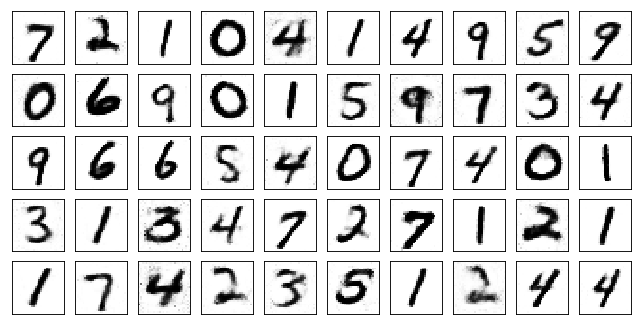

Test losses. G: 1.0361, D: 0.5439
Train Epoch: 96 [0/50000 (0%)]	Losses G: 1.0968, D: 0.5521
Train Epoch: 96 [5000/50000 (10%)]	Losses G: 0.9881, D: 0.6347
Train Epoch: 96 [10000/50000 (20%)]	Losses G: 0.9125, D: 0.6283
Train Epoch: 96 [15000/50000 (30%)]	Losses G: 0.9719, D: 0.5860
Train Epoch: 96 [20000/50000 (40%)]	Losses G: 1.0643, D: 0.5997
Train Epoch: 96 [25000/50000 (50%)]	Losses G: 0.8473, D: 0.5896
Train Epoch: 96 [30000/50000 (60%)]	Losses G: 1.0165, D: 0.5527
Train Epoch: 96 [35000/50000 (70%)]	Losses G: 1.0493, D: 0.6244
Train Epoch: 96 [40000/50000 (80%)]	Losses G: 0.9942, D: 0.5937
Train Epoch: 96 [45000/50000 (90%)]	Losses G: 1.0514, D: 0.6522
Train Epoch: 96 [50000/50000 (100%)]	Losses G: 0.8607, D: 0.5666


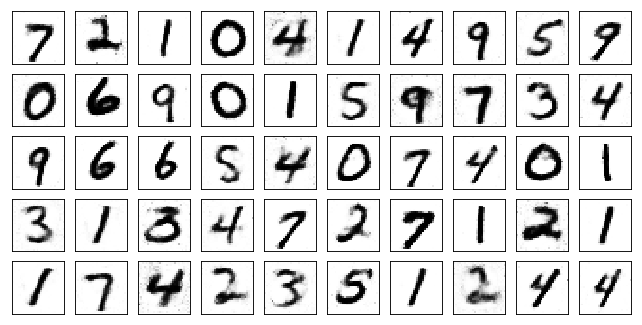

Test losses. G: 0.9121, D: 0.5354
Train Epoch: 97 [0/50000 (0%)]	Losses G: 0.8766, D: 0.6106
Train Epoch: 97 [5000/50000 (10%)]	Losses G: 1.0667, D: 0.5631
Train Epoch: 97 [10000/50000 (20%)]	Losses G: 1.0232, D: 0.5427
Train Epoch: 97 [15000/50000 (30%)]	Losses G: 1.1254, D: 0.5622
Train Epoch: 97 [20000/50000 (40%)]	Losses G: 0.9216, D: 0.5874
Train Epoch: 97 [25000/50000 (50%)]	Losses G: 1.1806, D: 0.5968
Train Epoch: 97 [30000/50000 (60%)]	Losses G: 0.9395, D: 0.5605
Train Epoch: 97 [35000/50000 (70%)]	Losses G: 0.9999, D: 0.5640
Train Epoch: 97 [40000/50000 (80%)]	Losses G: 0.9013, D: 0.5500
Train Epoch: 97 [45000/50000 (90%)]	Losses G: 0.9538, D: 0.6440
Train Epoch: 97 [50000/50000 (100%)]	Losses G: 1.1267, D: 0.5587


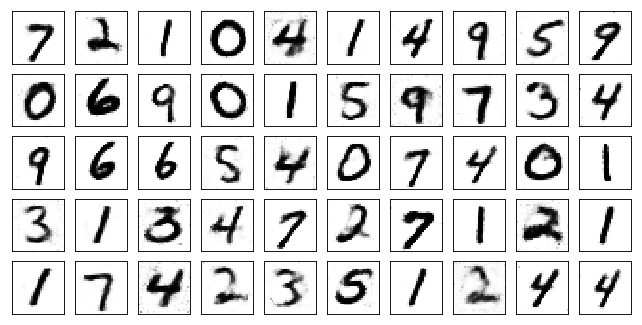

Test losses. G: 1.0404, D: 0.5509
Train Epoch: 98 [0/50000 (0%)]	Losses G: 0.9994, D: 0.6098
Train Epoch: 98 [5000/50000 (10%)]	Losses G: 1.0669, D: 0.6247
Train Epoch: 98 [10000/50000 (20%)]	Losses G: 1.0326, D: 0.5384
Train Epoch: 98 [15000/50000 (30%)]	Losses G: 1.1734, D: 0.6110
Train Epoch: 98 [20000/50000 (40%)]	Losses G: 1.1207, D: 0.5410
Train Epoch: 98 [25000/50000 (50%)]	Losses G: 1.2884, D: 0.5300
Train Epoch: 98 [30000/50000 (60%)]	Losses G: 0.9463, D: 0.5377
Train Epoch: 98 [35000/50000 (70%)]	Losses G: 1.0339, D: 0.5469
Train Epoch: 98 [40000/50000 (80%)]	Losses G: 1.2409, D: 0.5377
Train Epoch: 98 [45000/50000 (90%)]	Losses G: 1.0489, D: 0.5767
Train Epoch: 98 [50000/50000 (100%)]	Losses G: 1.0502, D: 0.5679


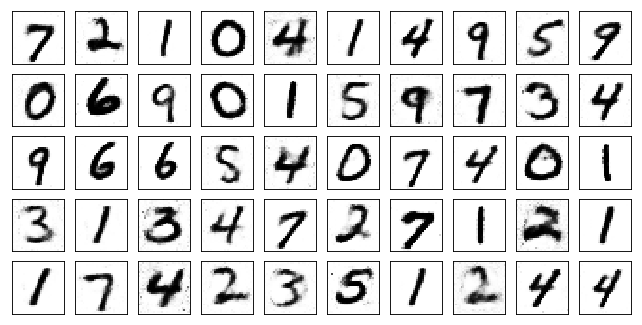

Test losses. G: 1.0627, D: 0.5337
Train Epoch: 99 [0/50000 (0%)]	Losses G: 1.1105, D: 0.5808
Train Epoch: 99 [5000/50000 (10%)]	Losses G: 0.9402, D: 0.6079
Train Epoch: 99 [10000/50000 (20%)]	Losses G: 0.9815, D: 0.6448
Train Epoch: 99 [15000/50000 (30%)]	Losses G: 0.9290, D: 0.6500
Train Epoch: 99 [20000/50000 (40%)]	Losses G: 1.2421, D: 0.5601
Train Epoch: 99 [25000/50000 (50%)]	Losses G: 1.0756, D: 0.5776
Train Epoch: 99 [30000/50000 (60%)]	Losses G: 1.0583, D: 0.6062
Train Epoch: 99 [35000/50000 (70%)]	Losses G: 1.0536, D: 0.6136
Train Epoch: 99 [40000/50000 (80%)]	Losses G: 0.9666, D: 0.6504
Train Epoch: 99 [45000/50000 (90%)]	Losses G: 0.8796, D: 0.5030
Train Epoch: 99 [50000/50000 (100%)]	Losses G: 0.8966, D: 0.5290


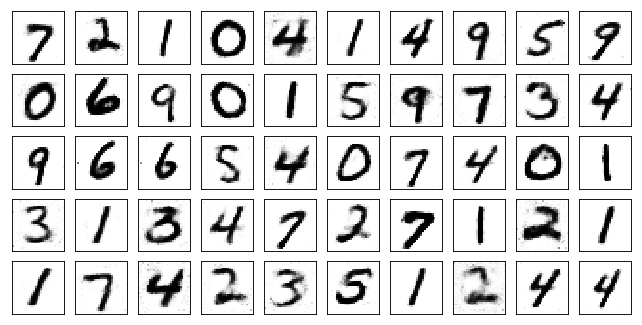

Test losses. G: 1.1423, D: 0.5085
Train Epoch: 100 [0/50000 (0%)]	Losses G: 0.9410, D: 0.6061
Train Epoch: 100 [5000/50000 (10%)]	Losses G: 1.0368, D: 0.6598
Train Epoch: 100 [10000/50000 (20%)]	Losses G: 1.0959, D: 0.6124
Train Epoch: 100 [15000/50000 (30%)]	Losses G: 1.1171, D: 0.6055
Train Epoch: 100 [20000/50000 (40%)]	Losses G: 1.1380, D: 0.5763
Train Epoch: 100 [25000/50000 (50%)]	Losses G: 1.0485, D: 0.6152
Train Epoch: 100 [30000/50000 (60%)]	Losses G: 1.0439, D: 0.5942
Train Epoch: 100 [35000/50000 (70%)]	Losses G: 1.0532, D: 0.6592
Train Epoch: 100 [40000/50000 (80%)]	Losses G: 0.9822, D: 0.6196
Train Epoch: 100 [45000/50000 (90%)]	Losses G: 1.0018, D: 0.5528
Train Epoch: 100 [50000/50000 (100%)]	Losses G: 1.0161, D: 0.6150


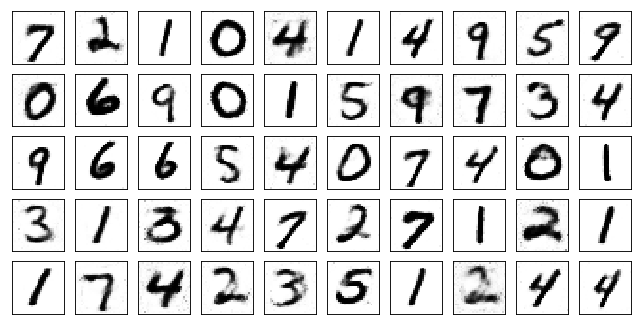

Test losses. G: 1.0500, D: 0.5489


In [13]:
for epoch in range(1, 101):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

In [14]:
torch.save(G, './generator_2')
torch.save(D, './discriminator_2')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [15]:
G = torch.load('./generator_2')

In [16]:
def show_generated_samples(cl):
    pred_z = torch.randn((50, 100))
    pred_cl = torch.ones(50, dtype=torch.long) * cl
    pred_oh = one_hot(y=pred_cl, batch_size=50)
    pred_h = torch.cat((pred_z, pred_oh), 1) 
       
    pred_gen = G(pred_h)
    generated = pred_gen.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()    
    plot_mnist(generated, (5, 10))

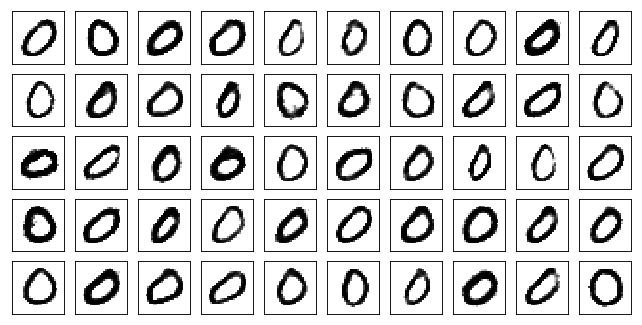

In [17]:
show_generated_samples(0)

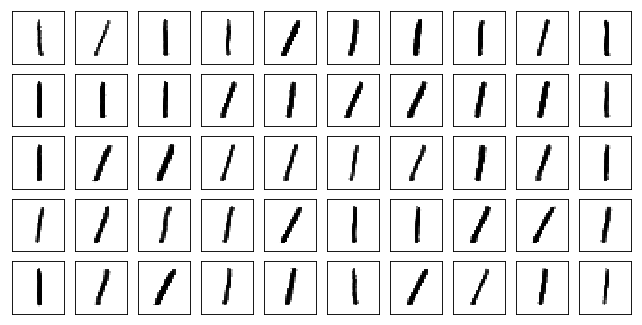

In [18]:
show_generated_samples(1)

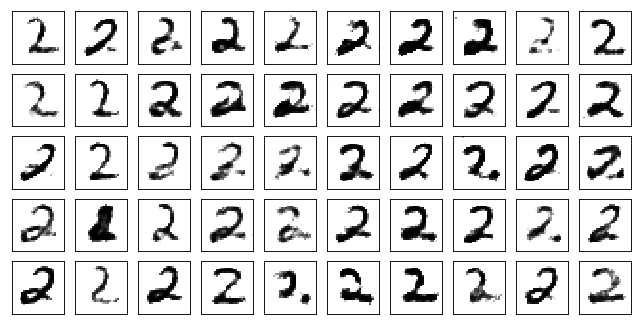

In [53]:
show_generated_samples(2)

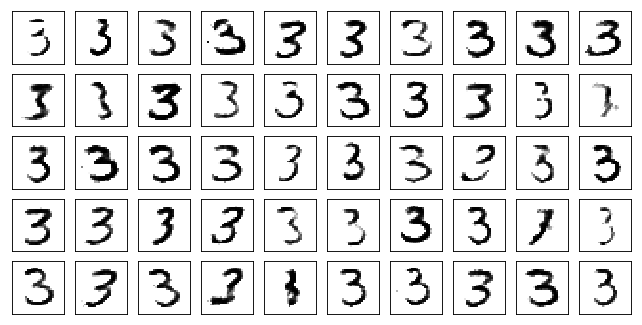

In [20]:
show_generated_samples(3)

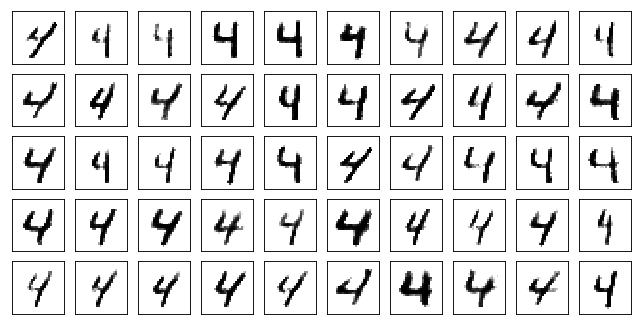

In [21]:
show_generated_samples(4)

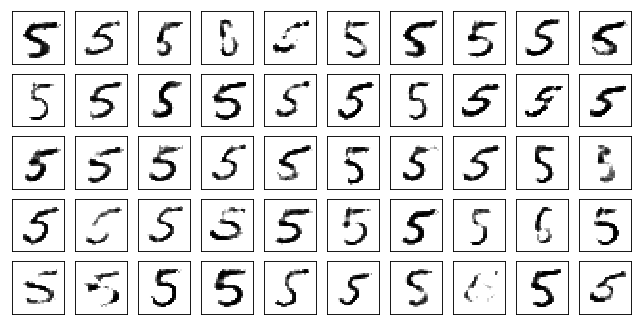

In [22]:
show_generated_samples(5)

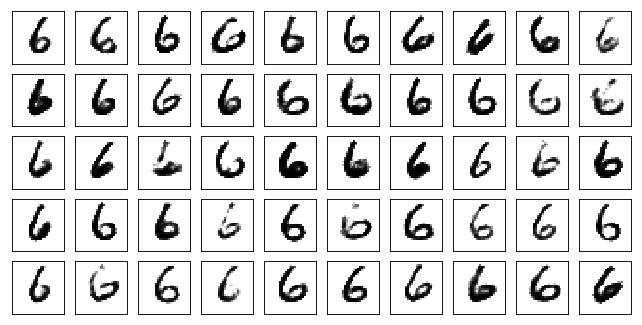

In [23]:
show_generated_samples(6)

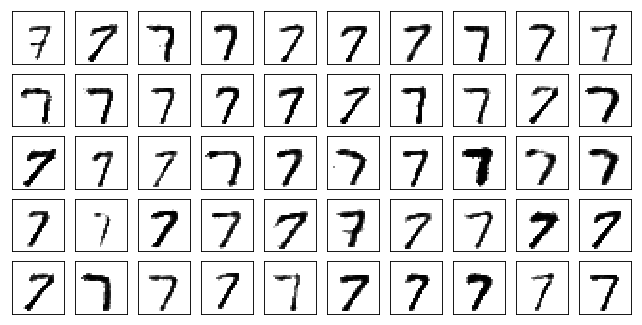

In [24]:
show_generated_samples(7)

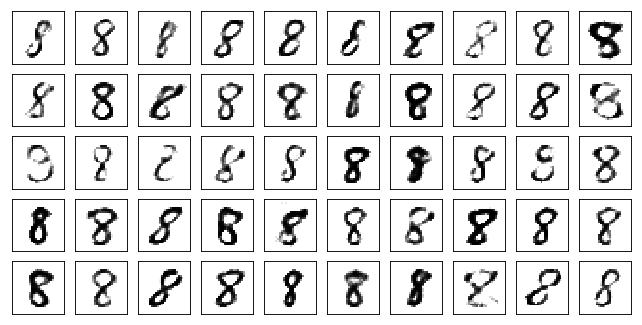

In [58]:
show_generated_samples(8)

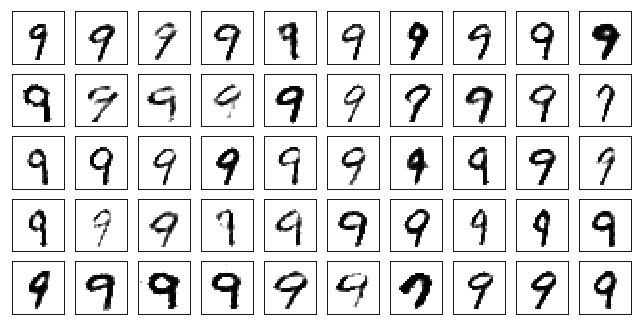

In [55]:
show_generated_samples(9)

### Вывод всех цифр в общем стиле

In [61]:
def show_common_style_images():
    images = torch.empty((0,0))
    for style in range(0,10):
        pred_z = torch.randn((1, 100))    
        for cl in range(0,10):
            pred_cl = torch.ones(1, dtype=torch.long) * cl
            pred_oh = one_hot(y=pred_cl, batch_size=1)
            pred_h = torch.cat((pred_z, pred_oh), 1) 

            img = G(pred_h)
            images = torch.cat((images, img), 0)
        
    to_plot = ((images.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
    plot_mnist(to_plot, (10, 10))

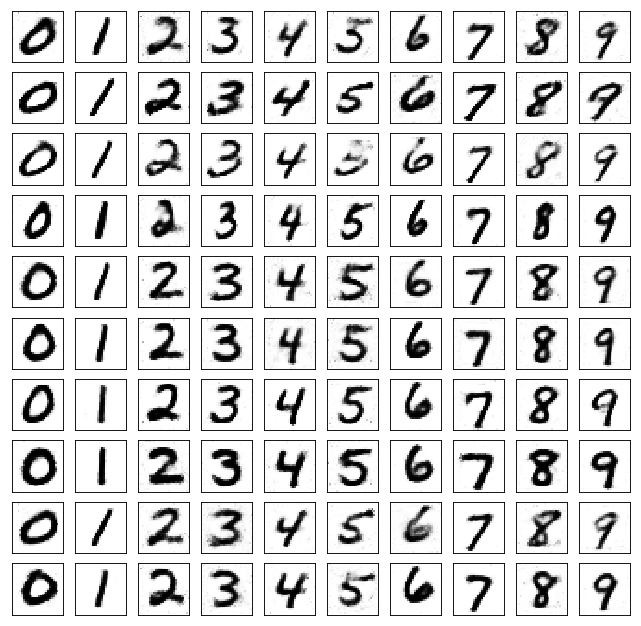

In [62]:
show_common_style_images()

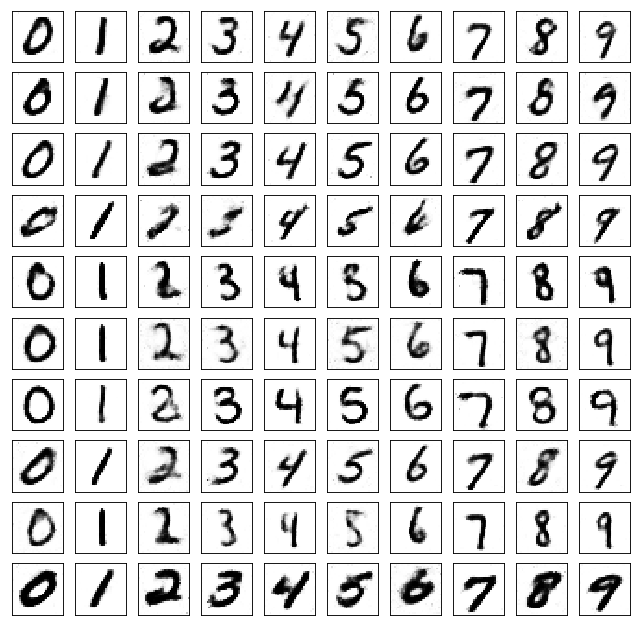

In [64]:
show_common_style_images()